This notebook was created while at Goddard on 1/23-1/25/2023. It is used for development of the code in trc_funcs.py.

Notes/To-dos for the end of the Goddard Visit:
- Structure
    - Turn Field into a class, with appropriate methods to build up a simulated field from a TPF
    - This is still in its very early stages, see the cells down below
    - need to think more about how to pass signals into the class
    - Funcs
        - making and applying background
        - adding sources w/ correct prf
        - adding signal to the sources
        - adding noise to the background and the sources
- PRFs
    - Switch to using the TESS_PRF package for now, keep your eyes open for the tess prf being incorporated into lightkurve
    - TESS_PRF: https://github.com/keatonb/TESS_PRF
    - kepler prf documentation: https://github.com/lightkurve/lightkurve/blob/843f0b5f20356d0ccc49d4b4f07005770d9d4e19/src/lightkurve/prf/prfmodel.py#L309
    - if you want the tess prf added to lightkurve sooner, consider writing your own pull request
- Mag to Flux calculation
    - The TESS zeropoint is 20.44 +/-0.05, can use this in the standard flux magnitude equation and it seems to keep things fairly close (to within ~10% of the right flux, based on a few examples that I checked.)
    - Another possibility is to use the gaia_rp_mean_flux, it is fairly close to the TESS bandpass and will get you most of the way there
    - available from the source catalog under the column 'gaiarp'
    - Other resource for bandpass fluxes: http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=TESS&asttype=
- fit_bkt() documentation
    - helpful link for understanding it: https://christinahedges.github.io/BuildingFastLinearModels/
- Noise models
    - Need to create an empirical noise model of pixel flux vs. standard deviation 
    - To do this, take chunks of TPFs on short ish time scale (~30 min) and get an empirical relationship for the above
    - investigate different sectors/camera/ccds just to make sure it's fairly consistent
- Velocity aberrations
    - ignore this for now, and follow up with Christina in ~2 work weeks
    - Look at the difference in poscorr between center of camera and edge of camera
    - 
- Other noise sources
    - Cosmic rays and straps -- ignore for now!

Science to discuss with Ruth:
- Stellar noise
    - What to add in besides just rotation? Easy ways to add things like flares, variable, EBs, transits?
    - What to add for background stars? I worry this is going to start getting *quite* computationally intensive.
    - How many fields? Do we want to reinject to the same fields?
- Tests
    - what sort of tests do we want to set up to make sure things are appropriately TESS-like?
- Quality flags
    - what to keep, what to manipulate?

Notes/To-dos for longer term:
- Packaging stuff
    - poetry
    - keep writing tests! 
    - set up github actions to do automatic testing
    - format docstrings
    - make pip installable
    - make docs with mkdocs
    - reference code/astro and astronomy workflow for all this: https://christinahedges.github.io/astronomy_workflow/index.html
 

In [334]:
# %matplotlib widget
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import astropy.wcs as wcs
import pandas as pd
import copy
import random

import butterpy as bp
import trc_funcs as trc
import PRF

# import eleanor
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.mast import Tesscut
from astropy.stats import sigma_clip
from scipy import stats
import scipy.signal
import astropy.table


In [1]:
# import phoebe

In [151]:
import imp
imp.reload(trc)

<module 'trc_funcs' from '/Users/raeholcomb/Documents/GitHub/tess_sim/tess_sim/trc_funcs.py'>

In [34]:
# plt.rcParams["figure.figsize"] = (5,4)
# plt.rcParams["figure.autolayout"] = True

## Unpacking data 

In [70]:
# unpack the tic overlap lists
# # save the overlap lists
# # ot_overlap =  oelker variable and tara variable
# # nt_overlap =  oelker non and tara non
# # vt_overlap = oelker non and tara variable
# # at_overlap = oelker non and tara non, exclude all gaia variables

with np.load('../local_data/tic_overlaps.npz', allow_pickle=True) as data:
    ot_overlap = data['ot_overlap']
    nt_overlap = data['nt_overlap']
    vt_overlap = data['vt_overlap']
    at_overlap = data['at_overlap']

In [3]:
# unpack dataframes
# read in LITE version of Tara's more complete variability catalog (has variables and non-variables)
tldf = pd.read_csv('../local_data/df_overlap_info.csv')
tldf.rename(columns={'ID':'TIC'}, inplace=True)
print(len(tldf))
tldf[:5]

199422


TIC   version          GAIA  KIC objType          ra        dec    Vmag  \
0  1078  20190415  6.222126e+18  0.0    STAR  218.813157 -28.228133  10.738   
1  1307  20190415  6.222241e+18  0.0    STAR  218.813657 -27.858749  10.912   
2  1454  20190415  6.223004e+18  0.0    STAR  218.755263 -27.601079  10.638   
3  1608  20190415  6.223044e+18  0.0    STAR  218.785116 -27.346680   9.773   
4  2042  20190415  6.223505e+18  0.0    STAR  218.736983 -26.623713  11.292   

   e_Vmag   Jmag  ...  numcont  contratio     RA_orig   Dec_orig      objID  \
0   0.014  8.682  ...      0.0        NaN  218.813191 -28.228143  913218723   
1   0.010  9.400  ...    161.0   0.006025  218.813665 -27.858884  913218893   
2   0.007  9.442  ...    150.0   0.010204  218.755267 -27.601149  913219000   
3   0.007  7.827  ...      0.0        NaN  218.785122 -27.346683  913219116   
4   0.057  8.710  ...      0.0        NaN  218.736953 -26.623717  912203542   

   num_s  num_scont  gaia_var  oelk_non  oelk_var  
0      2          1         0         0         0  
1      2          1         0         0         0  
2      2          1         0         1         0  
3      2          1         0         0         0  
4      2          1         0         0         0  

[5 rows x 34 columns]

In [5]:
# # read in Tara's variability catalog (VARIABLES ONLY)
tvdf = pd.read_csv('../LScatalog_combined_unique.csv')
print(len(tvdf))
tvdf[:10]

FileNotFoundError: [Errno 2] No such file or directory: '../LScatalog_combined_unique.csv'

In [8]:
# For now, grab a smaller data frame called the cdf
# which is what we will use while working with Christina
# # at_overlap = oelker non and tara non, exclude all gaia variables
cdf = tldf[tldf.TIC.isin(at_overlap)]
print(len(cdf))

41044


In [32]:
cdf[:5]

TIC   version          GAIA  KIC objType          ra        dec    Vmag  \
2    1454  20190415  6.223004e+18  0.0    STAR  218.755263 -27.601079  10.638   
6    3709  20190415  6.272082e+18  0.0    STAR  218.876538 -24.344873   9.272   
11  12678  20190415  6.223034e+18  0.0    STAR  219.227761 -27.390209   9.966   
12  12767  20190415  6.222276e+18  0.0    STAR  219.200724 -27.520580   9.948   
13  16598  20190415  6.223545e+18  0.0    STAR  219.307897 -26.202102  11.296   

    e_Vmag   Jmag  ...  numcont  contratio     RA_orig   Dec_orig      objID  \
2    0.007  9.442  ...    150.0   0.010204  218.755267 -27.601149  913219000   
6    0.004  7.565  ...      0.0        NaN  218.876350 -24.345075  913220745   
11   0.005  8.944  ...    137.0   0.052256  219.227796 -27.390252  914251986   
12   0.004  8.793  ...    161.0   0.014443  219.200593 -27.520691  914252075   
13   0.034  9.548  ...      0.0        NaN  219.307938 -26.202493  915302613   

    num_s  num_scont  gaia_var  oelk_non  oelk_var  
2       2          1         0         1         0  
6       2          1         0         1         0  
11      2          1         0         1         0  
12      2          1         0         1         0  
13      2          1         0         1         0  

[5 rows x 34 columns]

## Generate butterpy signals

In [29]:
np.random.seed(77)

period = 5.0    # in days

star = bp.regions(
    butterfly=True, 
    activity_rate=3,   # times solar rate
    cycle_length=5, 
    cycle_overlap=.5,   # 0 is pole on
    decay_time=(period*15),
    max_ave_lat=45, 
    min_ave_lat=20,
    alpha_med=(3*3e-4)
)

spots = bp.Spots(
    star, 
    alpha_med=(3*3e-4), 
    period=period,
    incl=1, 
    decay_timescale=10, 
    diffrot_shear=0.25
)

In [30]:
# set up mock lightcurve
time = np.arange(40, 200, .5)
flux = 1 + spots.calc(time)

lc = pd.DataFrame(np.c_[time, flux], columns=['time', 'flux'])


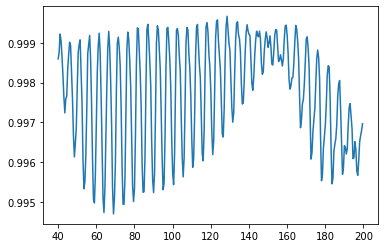

In [31]:
# modified

plt.plot(time,flux)
plt.show()

## Scratch

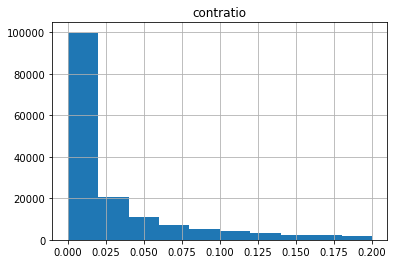

In [33]:
# Try to figure out if contratio is useful or not
tldf.hist(column="contratio")
plt.show()

In [34]:
tldf.sort_values(by=['contratio'], ascending=False, inplace=False)

TIC   version          GAIA  KIC   objType          ra  \
136042    302625238  20190415  5.217480e+17  0.0      STAR   28.347648   
187665    438613498  20190415  6.088420e+18  0.0      STAR  201.685053   
9813       21108045  20190415  6.077519e+18  0.0      STAR  186.850389   
96727     225040372  20190415  5.972951e+18  0.0      STAR  257.870724   
68262     157295117  20190415  4.523226e+18  0.0      STAR  274.650153   
...             ...       ...           ...  ...       ...         ...   
199416   2044088451  20190415  1.990987e+18  0.0      STAR  347.738178   
199418  10002431953  20190415  0.000000e+00  0.0  EXTENDED  184.610352   
199419  10005000001  20190415  0.000000e+00  0.0  EXTENDED   10.684710   
199420  10005000078  20190415  0.000000e+00  0.0  EXTENDED  187.705933   
199421  10005000539  20190415  0.000000e+00  0.0  EXTENDED  250.423477   

              dec    Vmag  e_Vmag    Jmag  ...  numcont  contratio  \
136042  70.042622   8.890   0.030   8.292  ...    398.0   0.199942   
187665 -43.864090  10.169   0.007   8.454  ...    344.0   0.199929   
9813   -51.923067  15.942   0.011  11.879  ...    718.0   0.199919   
96727  -39.314583  10.943   0.012   9.058  ...   3164.0   0.199919   
68262   17.714064  11.676   0.048  10.112  ...    572.0   0.199916   
...           ...     ...     ...     ...  ...      ...        ...   
199416  50.050920     NaN     NaN     NaN  ...      0.0        NaN   
199418  29.812820     NaN     NaN  11.101  ...      0.0        NaN   
199419  41.268749     NaN     NaN   2.094  ...      0.0        NaN   
199420  12.391100     NaN     NaN   6.719  ...      0.0        NaN   
199421  36.461319     NaN     NaN   4.452  ...      0.0        NaN   

           RA_orig   Dec_orig       objID  num_s  num_scont  gaia_var  \
136042   28.347889  70.042642    26216355      6          2         2   
187665  201.685456 -43.864160   850486584      3          1         0   
9813    186.848839 -51.922909   800619672      4          2         0   
96727   257.870686 -39.314925  1192179577      3          1         0   
68262   274.650081  17.713652   191433637      3          1         0   
...            ...        ...         ...    ...        ...       ...   
199416  347.738216  50.050921   494433464      3          2         2   
199418         NaN        NaN  1727181931      1          1         2   
199419         NaN        NaN  1727248513      2          1         0   
199420         NaN        NaN  1727248565      2          1         0   
199421         NaN        NaN  1727248801      4          2         0   

        oelk_non  oelk_var  
136042         0         0  
187665         0         0  
9813           0         0  
96727          0         0  
68262          0         0  
...          ...       ...  
199416         0         0  
199418         0         0  
199419         0         0  
199420         0         0  
199421         0         0  

[199422 rows x 34 columns]

In [44]:
# grab "crowded" example from lightkurve tutorial, check contratio
lc = lk.search_lightcurve("KIC 2437317", author="Kepler", cadence="long", quarter=10).download(quality_bitmask="hard")
print(lc.meta['CROWDSAP'])

0.9765


In [80]:
# grab "crowded" example from lightkurve tutorial, check contratio
lc = lk.search_lightcurve("KIC 2437901", author="Kepler", cadence="long", quarter=10).download(quality_bitmask="hard")
print(lc.meta['CROWDSAP'])

0.9915


In [50]:
# Check CROWDSAP for Tara's "contaminated" targets
# tic 302625238
lc = lk.search_lightcurve("TIC 302625238", author='SPOC').download(quality_bitmask="hard")
print(lc.meta['CROWDSAP'])



/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


0.82462317


In [90]:
# pick 10 random TICS from the sorted tldf
# rand_inds should be good to use!
# rand_inds1 = np.rint((np.logspace(0, 1, num=10)-1) * len(tldf)/10).astype(int)
rand_inds = np.rint((np.logspace(0, 2, num=10)-1)/10 * len(tldf)/10).astype(int)
rand_inds2 = np.rint((np.logspace(0, 2, num=20)-1)/10 * len(tldf)/10).astype(int)
print(rand_inds)
print(rand_inds1)
# plt.plot(rand_inds)
# plt.plot(rand_inds1)
plt.show()

[     0   1332   3555   7262  13446  23762  40970  69674 117556 197428]
[     0   5814  13323  23022  35548  51726  72621  99608 134463 179480]


In [91]:
tldf.sort_values(by=['contratio'], ascending=False, inplace=False).iloc[rand_inds2]

TIC   version          GAIA        KIC objType          ra  \
136042  302625238  20190415  5.217480e+17        0.0    STAR   28.347648   
10649    22242383  20190415  6.148012e+18        0.0    STAR  183.621638   
22517    47245744  20190415  5.756094e+18        0.0    STAR  134.671194   
57977   141714191  20190415  5.266125e+18        0.0    STAR   91.235010   
87968   199666111  20190415  1.432072e+18        0.0    STAR  251.904145   
29092    63009781  20190415  2.126164e+18  8165738.0    STAR  291.788067   
48227   117403375  20190415  4.398527e+17        0.0    STAR   48.387986   
32057    68901227  20190415  1.355676e+18        0.0    STAR  249.690583   
118047  265870350  20190415  3.456445e+18        0.0    STAR   86.982458   
189903  441946248  20190415  5.307887e+18        0.0    STAR  145.753048   
116521  262412046  20190415  3.279226e+18        0.0    STAR   69.276486   
120738  270946576  20190415  5.523723e+18        0.0    STAR  132.096646   
173235  396696273  20190415  4.778975e+18        0.0    STAR   65.302278   
111199  252693033  20190415  1.995133e+18        0.0    STAR  347.240527   
3243      7772500  20190415  2.121646e+18        0.0    STAR  274.193702   
132327  293223210  20190415  5.478313e+18        0.0    STAR   98.332446   
55869   139150757  20190415  9.053102e+17        0.0    STAR  120.797011   
78762   175287761  20190415  6.552935e+18        0.0    STAR  346.941789   
55593   138908413  20190415  4.007230e+18        0.0    STAR  179.548137   
191657  448471695  20190415  5.400754e+18        0.0    STAR  165.959961   

              dec    Vmag  e_Vmag    Jmag  ...  numcont  contratio  \
136042  70.042622   8.890   0.030   8.292  ...    398.0   0.199942   
10649  -42.970765  12.735   0.069  10.004  ...    243.0   0.193607   
22517   -7.993618  10.671   0.007   9.469  ...     88.0   0.185688   
57977  -72.853347  12.814   0.126  10.944  ...    757.0   0.176166   
87968   59.909007  10.038   0.005   8.884  ...     54.0   0.165679   
29092   44.080028  11.423   0.013  10.381  ...    469.0   0.153066   
48227   51.301287  12.816   0.103  11.146  ...    333.0   0.139182   
32057   39.389028  11.767   0.023  10.453  ...     49.0   0.123784   
118047  37.709269  13.101   0.041  10.352  ...    399.0   0.107671   
189903 -55.594584   9.968   0.004   8.882  ...   1794.0   0.091283   
116521   1.691988  11.086   0.011  11.212  ...     63.0   0.074264   
120738 -44.207139  13.316   0.015   9.689  ...    532.0   0.058094   
173235 -55.144022  17.500   0.200  12.254  ...     61.0   0.043651   
111199  51.874875  16.643   0.297  12.157  ...    482.0   0.030996   
3243    47.116194  11.171   0.010   9.847  ...    137.0   0.020207   
132327 -61.872583  14.114   0.061  10.953  ...    118.0   0.011972   
55869   33.596474  10.160   0.030   8.161  ...     68.0   0.006037   
78762  -37.114953   9.900   0.005   8.466  ...     37.0   0.002066   
55593   26.911619   9.372   0.002   8.453  ...     27.0   0.000058   
191657 -35.695517  10.951   0.008   9.031  ...      0.0        NaN   

           RA_orig   Dec_orig       objID  num_s  num_scont  gaia_var  \
136042   28.347889  70.042642    26216355      6          2         2   
10649   183.621277 -42.970876   791253798      3          1         0   
22517   134.670940  -7.994428   660847491      3          1         0   
57977    91.235296 -72.853010   557472463     35         13         0   
87968   251.904034  59.909049   163511964     28         13         0   
29092   291.788140  44.080006   286078884      5          2         0   
48227    48.389004  51.300567    43973572      2          1         0   
32057   249.690603  39.388751   162198380      4          2         0   
118047   86.982751  37.708891    89823473      2          1         0   
189903  145.753141 -55.594881   687400564      5          2         0   
116521   69.276459   1.691962    65009130      2          1         2   
120738  132.096894 -44.207975   655128141      5          2         0 

/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


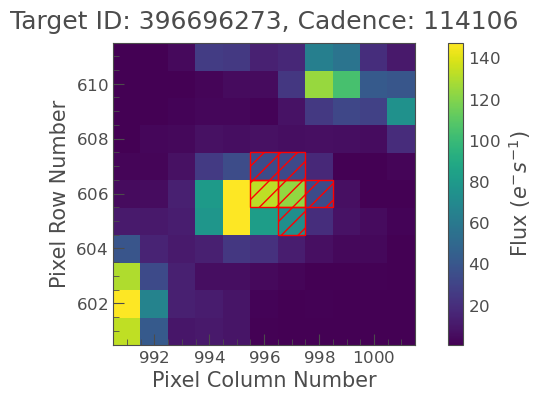

In [94]:
tpf_crowded = lk.search_targetpixelfile("TIC 396696273", author='SPOC').download(quality_bitmask="hard")
# print(tpf_crowded.meta['CROWDSAP'])

# lk.search_targetpixelfile("KIC 2437901", author="Kepler", cadence="long", quarter=10).download(quality_bitmask="hard")
tpf_crowded.plot(aperture_mask='pipeline');

In [ ]:
# list of approved fields
# Crowded (hopefully?)
# TIC 252606684 - 2 continuous sectors
# TIC 141714191 - 13 sec
# TIC 199666111 - 13 sec


# Medium
# 

# Uncrowded


# Developing Goddard Pipeline 

In [9]:
imp.reload(trc)

<module 'trc_funcs' from '/Users/raeholcomb/Documents/GitHub/tess_sim/tess_sim/trc_funcs.py'>

### Download data

In [4]:
# pick a star/field to work with
tic = 396696273
# tic = 199666111
name = "TIC " + str(tic)
# ra,dec = tldf.loc[tldf.TIC==tic]['ra'].values[0], tldf.loc[tldf.TIC==tic]['dec'].values[0]


In [4]:
# postage stamp tpf from pipeline
tpf_pl = lk.search_targetpixelfile(name, sector=3, exptime=1800).download(quality_bitmask="hard")
tpf_pl

NameError: name 'name' is not defined

/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 7 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


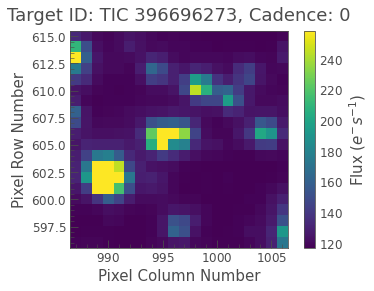

In [6]:
# grab the real TESS cut out
cutout_size=20
tpf_cutout = trc.get_cutout(name, cutout_size=cutout_size)
tpf_cutout.plot();

# grab the catalog of sources
source_cat = trc.get_catalog(name, cutout_size=cutout_size)


In [7]:
# get a large cut out for further testing
big_size = 50
tpf_big = trc.get_cutout(name, cutout_size=big_size)
tpf_big.plot();

# grab the catalog of sources
source_big = trc.get_catalog(name, cutout_size=big_size)


/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 7 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


KeyboardInterrupt: 

In [8]:
tpf_cutout.meta
source_cat[1]['gaiarp']

13.1247

In [8]:
tpf_cutout.animate()

### Flux Conversions

In [9]:
# flux to mag conversions - NOT WORKING
def flux_to_mag_old(flux, reference_flux=1.74e5):
    """NOTE: ref mag is a place holder from kepler right now!"""
    kepmag = 12 - 2.5 * np.log10(flux/reference_flux)
    return kepmag

def mag_to_flux_old(mag, reference_flux=1.74e5):
    """NOTE: ref mag is a place holder from kepler right now!"""
    fkep = (10.0**(-0.4*(mag - 12.0)))*reference_flux
    # f12 = 1.74e5 # electrons/sec
    return fkep

def mag_to_flux(mag, reference_flux=2486.30):
    """NOTE: ref mag is a place holder from kepler right now!"""
    fkep = (10.0**(-0.4*(mag)))*reference_flux
    # f12 = 1.74e5 # electrons/sec
    return fkep

# this equation gives flux in ergs/s, need in e-/s
lambda_ref = 7697.58
def func(flux):
    return 1/(2.9979246) * 1e5 * (lambda_ref**2) * flux

mag = source_cat[0]['Tmag']
print(mag)
mag_to_flux_old(mag, reference_flux=2486.30)


13.8321


459.9530785022862

TessTargetPixelFile(TICID: 199666111)


/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 31 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


9.45394993
24798.192559387226
9.45394993


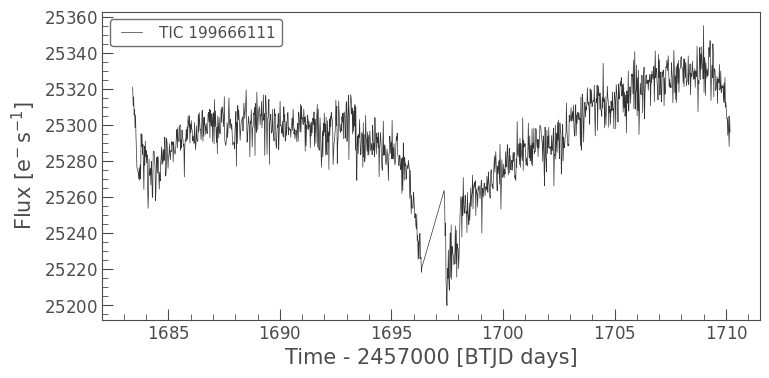

In [72]:
# download random TPF to check the mag/flux conversions
temp = lk.search_targetpixelfile('TIC 199666111').download(quality_bitmask="hard")

# print(temp)

Tmag = temp.meta['TESSMAG']
flux = trc.mag_to_flux(Tmag)
print(Tmag)
print(trc.mag_to_flux(Tmag))
print(trc.flux_to_mag(flux))

temp.to_lightcurve(aperture_mask="pipeline").plot()
plt.show()


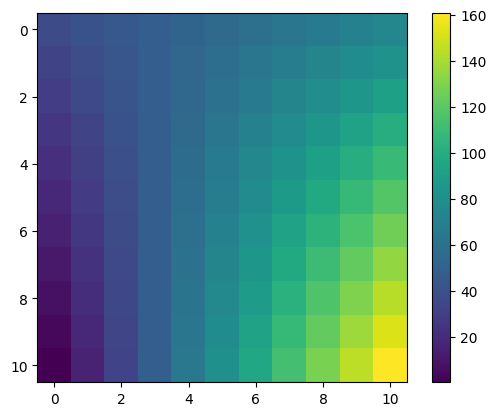

In [78]:
# do a quick check of the background contribution
bkg_temp = trc.fit_bkg(temp, polyorder = 1)
plt.imshow(bkg_temp[0])
plt.colorbar()

13.8321
439.70357838610386
13.8321


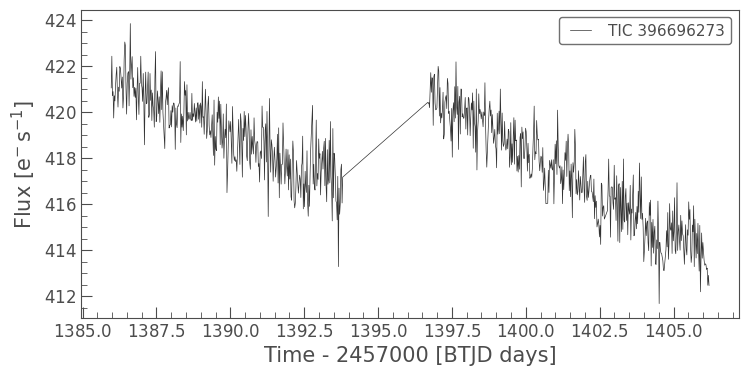

In [67]:

ind = 0
temp = lk.search_targetpixelfile('TIC ' + source_cat[ind]['ID'], sector=3, exptime=1800).download(quality_bitmask="hard")

Tmag = source_cat[ind]['Tmag']
flux = trc.mag_to_flux(Tmag)
print(Tmag)
print(trc.mag_to_flux(Tmag))
print(trc.flux_to_mag(flux))

temp.to_lightcurve(aperture_mask="pipeline").plot()
plt.show()


In [33]:
# T = -2.5 log10(flux) + zeropoint
# Where the zeropoint for TESS images is 20.44 +/-0.05, which is the average zeropoint across all TESS dectectors.
# I think solving it backwards from magnitude to flux would give you what you’re asking for:
# 

Tmag = source_cat[0]['Tmag']
zeropoint = 20.44
flux =  10 ** (-(Tmag - zeropoint)/2.5)
print(flux)
print(trc.mag_to_flux(Tmag))
print(trc.flux_to_mag(flux))



439.70357838610386
439.70357838610386
13.8321


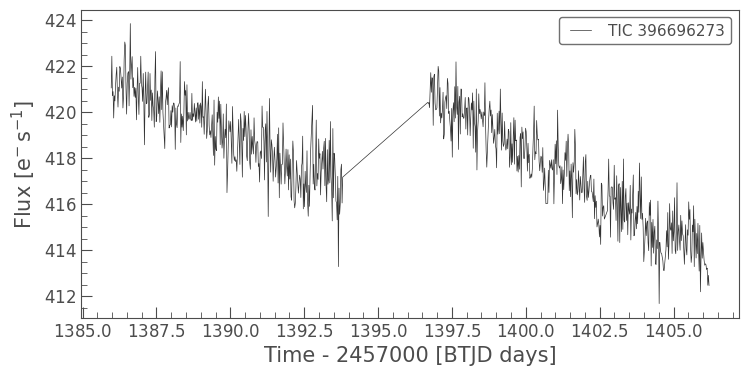

In [27]:
tpf_pl.to_lightcurve(aperture_mask="pipeline").plot()
plt.show()

### Gaussian field + bkg testing

121.848206
(1077, 20, 20)


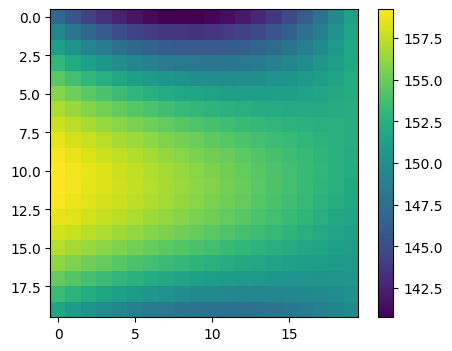

In [ ]:
# work on modeling the background
# first step is to use the source catalog to mask sources
print(np.median(tpf_cutout[0].flux.value))
np.median(tpf_cutout.flux.value, axis=[1,2])

# bkg = trc.estimate_bkg(tpf_cutout, source_cat)
# plt.close('all')
bkg = trc.fit_bkg(tpf_cutout, polyorder=2)
print(np.shape(bkg))
plt.figure(figsize=[5,4])
plt.imshow(bkg[100])
plt.colorbar()
plt.show()



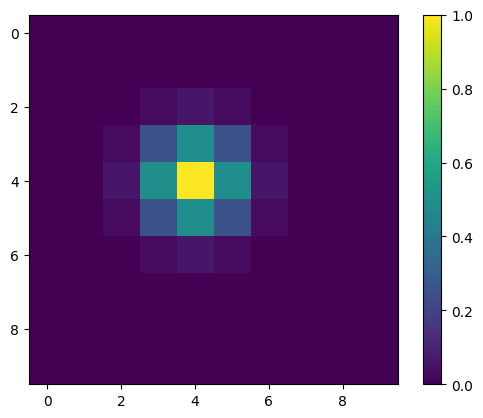

4.532371887240516 7.3890560989306495


In [14]:
# work on gaussian smearing the sources
imp.reload(trc)

def makeGaussian(size_x, size_y, fwhm = 1.3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum (units of pixels), which
    can be thought of as an effective radius.

    Note: NOT normalized correctly! But that shouldn't matter.
    """
    x = np.arange(0, size_x, 1, float)[np.newaxis, :]
    y = np.arange(0, size_y, 1, float)[:, np.newaxis]

    if center is None:
        x0 = size_x // 2
        y0 = size_y // 2
    else:
        x0 = center[0]
        y0 = center[1]

    # make and normalize so that the who image sums to 1
    arr = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    return arr


out = trc.makeGaussian(10, 10, fwhm=2, center=[4,4])
plt.imshow(out)
plt.colorbar()
plt.show()
print(np.sum(out), np.e**2)

In [ ]:
# lightkurve/src/lightkurve/prf
# SimpleKeplerPRF

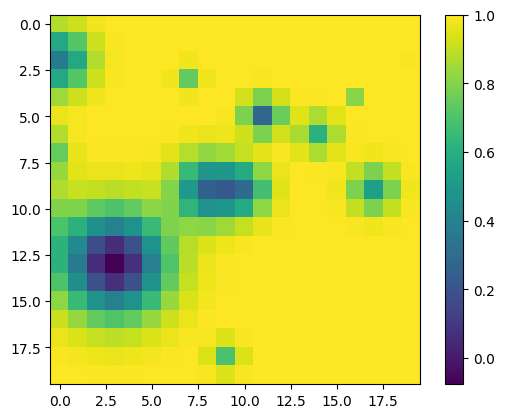

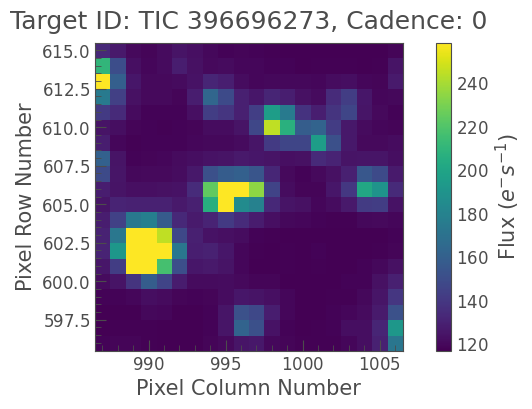

In [67]:
imp.reload(trc)
def generate_gaussian_field(tpf_cutout, source_cat, plot=False, buffer=3):
    """Given a source catalog and tpf_cutout, generates a field with gaussian sources. Currently is very jank and just proof of concept. The list of sources in read in and then the single pixel nearest their location is given a value weighed by 16-Tmag. The plot keyword will plot the tpf_cutout and the basic field, rotated so that they hopefully line up. 

    Inputs (incomplete):
        buffer - the code will ignore any targets provided that fall more than this number of pixels outside of the tpf

    Known issues: 
    - Values are not real fluxes 
    - the pixel numbers on the axes don't line up with the real tpf pixel numbers 
    - jank rounding for ra/dec --> pixel conversion
    """
    # set up field
    shape = tpf_cutout.shape[1:]
    field = np.ones(shape)

    # convert source coords to integer pixel numbers
    pix1, pix2 = np.rint(tpf_cutout.wcs.all_world2pix(source_cat['ra'], source_cat['dec'], 0)).astype(int)

    # cut out indices where the target falls significantly outside the cutout
    cut = (pix1 < shape[0]+buffer) & (pix1 >= 0-buffer) & (pix2 < shape[1]+buffer) & (pix2 >= 0-buffer)
    source_cut = source_cat[cut]

    # add sources to the field, weighted by Tmag
    fwhm_arr = 16 - source_cat['Tmag'][cut]
    for source_ind in range(len(source_cut)):
        # make the gaussian
        gauss = trc.makeGaussian(shape[0], shape[1], fwhm=fwhm_arr[source_ind], center=[pix1[source_ind],pix2[source_ind]]) * fwhm_arr[source_ind]

        # add in a signal
        signal = np.sin(tpf_cutout.time.value)
        gauss_blink = np.multiply(signal[:, np.newaxis, np.newaxis], gauss[np.newaxis, :, :])

        # add to the field
        field = np.add(field, gauss_blink)
        # field = np.add(field, gauss[np.newaxis, :, :])
        # field[:,pix1[cut],pix2[cut]] = 16 - source_cat['Tmag'][cut]

    # plot if requested
    if plot:
        plt.imshow(np.rot90(field[0].T))
        plt.colorbar()
        plt.show()
        tpf_cutout.plot();
    
    return field

gauss_field = generate_gaussian_field(tpf_cutout, source_cat, plot=True, buffer=3)

In [68]:
# build new tpf
import copy
test = copy.copy(tpf_cutout)
test = test * 0
test += gauss_field
test.animate()

### Develop the Field Class

Field Class Workflow

Fields should be designed to be highly mutable and interactive by the user. All reasonable options should be accessible to the user. They should also supply as many reasonable default options as possible, so that it is easy for users to input the things they care about and then have the rest taken care of for them.

I'm thinking, we'll have a set up where the user initializes the field and then needs to call functions in an "assembly line" to populate the internal variables. Then there will be a final "assemble everything function" that puts it all together and outputs a TPF.

The final Field object should have all its ingredients that went into it be individually call-able (or the information to reproduce them be call-able). This includes the background, the plain sources, the injected signals, and the inputted noise at the end.

In [152]:
# Develop the Field class
import astropy.table

class Field():
    """Creates an array that """
    def __init__(self, orig_tpf: lk.TessTargetPixelFile,
        source_cat: astropy.table,
        bkg_polyorder: int, 
        pos_time=None, pos_corr1=None, pos_corr2=None):

        # define some useful variables
        self.orig_tpf = orig_tpf
        self.source_cat = source_cat
        self.shape = orig_tpf.shape[1:]
        self.field = np.zeros(self.shape)
        self.cam = orig_tpf.meta['CAMERA']
        self.ccd = orig_tpf.meta['CCD']
        self.sector = orig_tpf.meta['SECTOR']

        # grab the prf
        self.prf = PRF.TESS_PRF(self.cam,self.ccd,self.sector,
                    self.orig_tpf.column,self.orig_tpf.row)
        
        # define the differential velocity aberrations
        # pos_corr should be in the format [x_diff, y_diff] in units of pixels
        if pos_time is not None:
            self.pos_corr = self.prep_positional_data(pos_time, pos_corr1, pos_corr2)
        else:
            # if no positional deviation information is supplied, populate the matrices with zeros
            self.pos_corr = np.zeros([2,len(self.orig_tpf)])

        # fit a background and add it to the field
        self.bkg = self.fit_bkg(polyorder=bkg_polyorder)
        
        # final assembly
        self.field = np.add(self.field, self.bkg)

    def prep_positional_data(self, pos_time, pos_corr1, pos_corr2):
        """Takes the pos_corr1 and pos_corr2 data and casts it into an array matching the time array, which can then be used to calculate the velocity aberrations."""
        # recast arrays to the right shape
        time_bin = self.orig_tpf.time.value
        pc1 = stats.binned_statistic(pos_time, pos_corr1, bins=time_bin)[0]
        pc2 = stats.binned_statistic(pos_time, pos_corr2, bins=time_bin)[0]
        # append extra element to the end to make the lengths match
        pc1 = np.append(pc1, pc1[-1])
        pc2 = np.append(pc2, pc2[-1])

        # forward fill any nans
        pc1 = trc.forward_fill(pc1)
        pc2 = trc.forward_fill(pc2)

        # after doing this, there may still be some nans left at the very beginning of the array
        # solve by backwards filling any nans as well
        pc1 = trc.backward_fill(pc1)
        pc2 = trc.backward_fill(pc2)

        return [pc1, pc2]

    def add_source(self, signal_func, buffer=3):
        """Adds a source with a given flux and position to the Field.
        signal - a 1d array that gives the behavior of the source over time, normalized to 1."""
        
        # convert source coords to pixel numbers and int pixel numbers
        pix1, pix2 = self.orig_tpf.wcs.all_world2pix(self.source_cat['ra'], self.source_cat['dec'], 0)
        pix1int = np.rint(pix1).astype(int)
        pix2int = np.rint(pix2).astype(int)

        # convert flux to mag (FIX LATER)
        flux_arr = trc.mag_to_flux(self.source_cat['Tmag'])

        # cut out indices where the target falls significantly outside the cutout
        cut = (pix1int < self.shape[0]+buffer) & (pix1int >= 0-buffer) & (pix2int < self.shape[1]+buffer) & (pix2int >= 0-buffer)
        source_cut = self.source_cat[cut]

        # retrieve the prf for this tpf
        # Suppose the following for a TPF of interest
        cam = self.orig_tpf.meta['CAMERA']
        ccd = self.orig_tpf.meta['CCD']
        sector = self.orig_tpf.meta['SECTOR']
        colnum = self.orig_tpf.column #middle of TPF?
        rownum = self.orig_tpf.row #middle of TPF?

        # add sources to the field, weighted by Tmag
        for source_ind in range(len(source_cut)):
        # for source_ind in range(1,2):
            # add the signal to the source
            # signal = flux_arr[source_ind] + 10*np.sin(self.orig_tpf.time.value * np.random.uniform(.5, 1.5))
            signal = flux_arr[source_ind] * signal_func(self.orig_tpf.time.value)

            # resample to make the prf for the source
            # source_prf = self.prf.locate(pix1[source_ind],pix2[source_ind], self.shape)
            try:
                source_prf = [self.prf.locate(pix1[source_ind]+self.pos_corr[0][i], pix2[source_ind]+self.pos_corr[1][i], self.shape) for i in range(len(self.orig_tpf))]
            except:
                print(source_ind)

            # apply the prf to the signl and add to image
            # gauss_blink = np.multiply(signal[:, np.newaxis, np.newaxis], source_prf[np.newaxis, :, :])
            gauss_blink = np.multiply(signal[:, np.newaxis, np.newaxis], source_prf)

            # add to the field
            self.field = np.add(self.field, gauss_blink)
            # field = np.add(field, gauss[np.newaxis, :, :])
            # field[:,pix1[cut],pix2[cut]] = 16 - self.source_cat['Tmag'][cut]

        return

    def add_sources_from_catalog(self):
        """Given a catalog of sources, adds each of them to the Field."""
        return

    def fit_bkg(self, polyorder=1):
        """Adds background to the Field. Should only be called once."""
        return trc.fit_bkg(self.orig_tpf, polyorder=polyorder)

    def add_empirical_noise(self):
        """Adds """

    def to_tpf(self):
        """Converts the field to a TargetPixelFile."""
        out_file = copy.copy(self.orig_tpf)
        out_file = out_file * 0
        out_file += self.field
        return out_file
    

In [155]:
np.shape(field1.field)

(1077, 20, 20)

In [154]:
# test Field class
def signal_test(time):
    """Placeholder for a signal added to a star"""
    return 1 + 0.1 * np.sin(time * np.random.uniform(.5, 1.5))

# test = signal_test(tpf_cutout.time.value)
# plt.plot(tpf_cutout.time.value, test)
# plt.show()

# type(source_cat)

field1 = Field(tpf_cutout, source_cat , bkg_polyorder=2, pos_time=tpf_pl.time.value, pos_corr1=tpf_pl.pos_corr1*10, pos_corr2=tpf_pl.pos_corr2*10)
field1.add_source(signal_test)
field1.to_tpf().animate(clim=[120,260])



### Investigate pos_corr drifts

1077
1066
1077


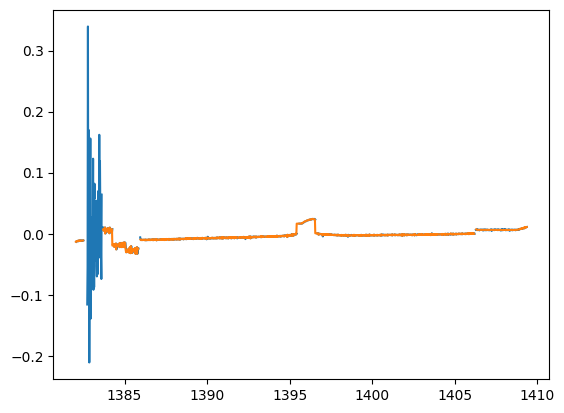

In [610]:
time_bin = tpf_cutout.time.value
new_bin = stats.binned_statistic(real_tpf.time.value, real_tpf.pos_corr1, bins=time_bin)[0]
new_bin = np.append(new_bin, new_bin[-1])

print(len(new_bin))
print(np.count_nonzero(~np.isnan(new_bin)))
print(np.count_nonzero(~np.isnan(trc.forward_fill(new_bin))))
plt.plot(real_tpf.time.value, real_tpf.pos_corr1)
plt.plot(time_bin,new_bin)
plt.show()

In [587]:
len(lk.search_tesscut("TIC 396696273")[0].download(quality_bitmask='default'))


1077

In [602]:
real_tpf = lk.search_targetpixelfile("TIC 396696273")[1].download(quality_bitmask='none')
print(len(real_tpf))

1312


(880, 11, 11)


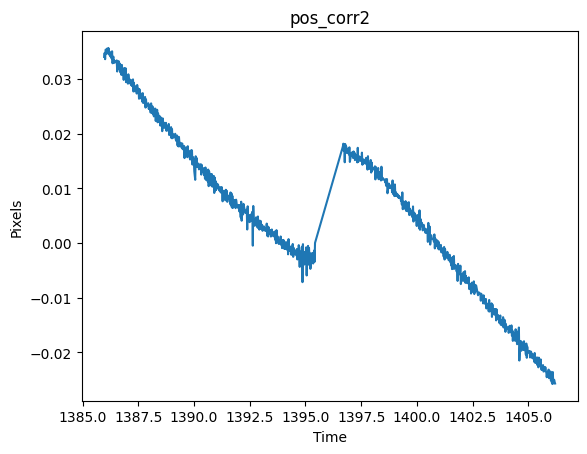

In [548]:
print(real_tpf.shape)
plt.plot(real_tpf.time.value, real_tpf.pos_corr2)
plt.title('pos_corr2')
plt.xlabel('Time')
plt.ylabel('Pixels')
plt.show()

In [499]:
arr = [field1.prf.locate(5.0+field1.vel_diff[0][i], 5.0+field1.vel_diff[1][i], (11,11)) for i in range(len(field1.orig_tpf))]

print(np.shape(arr))

(1077, 11, 11)


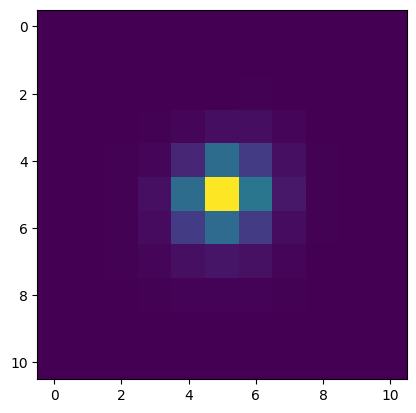

In [501]:
np.shape(arr[0])
plt.imshow(arr[0])
plt.show()

In [317]:
np.shape(field1.prf)

()

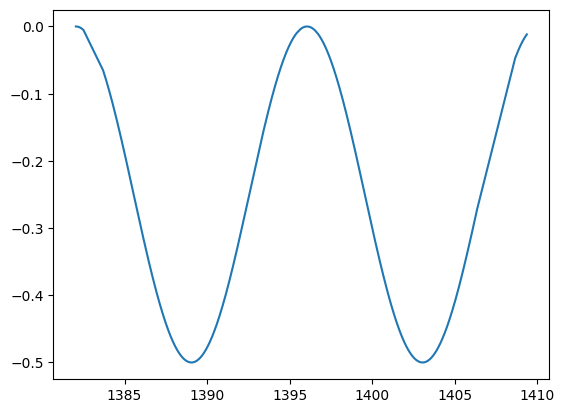

In [512]:
def diff_velocity_aberration(time, amp1, amp2):
    """Calculates a toy model of the differential velocity abberation in pixels on the CCD over a period of time. Orbits are currently assumed to be 14 days, and start at the beginning of the time stamp. This may be modified later to be more realistic.
    
    Returns the position drift in units of pixels as [x_diff, y_diff]. Inputs are the time array and the amplitude of the drift along the x and y directions."""
    orbit_per = 14
    x_diff = amp1 * np.sin( np.pi / (orbit_per) * (time - time[0]) )**2
    y_diff = amp2 * np.sin( np.pi / (orbit_per) * (time - time[0]) )**2
    return x_diff, y_diff

time = tpf_cutout.time.value

plt.plot(time, diff_velocity_aberration(time, 1, -.5)[1])
plt.show()


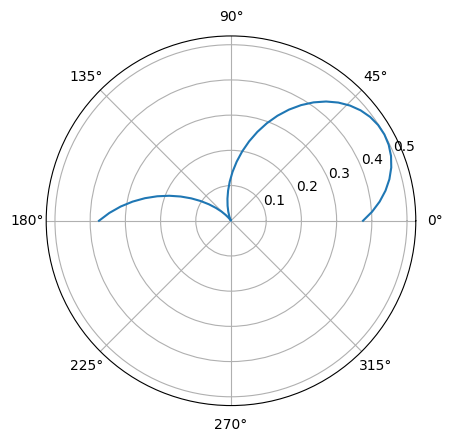

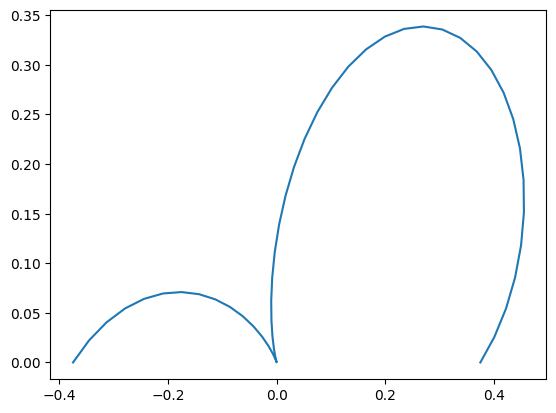

In [445]:
# Develop Velocity Abberation code
# differential velocity aberrations, meaning that it should be centered around zero

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

t = np.linspace(0, 2*np.pi, 50)
# rho = np.sin(t+np.pi/3) / 2
rho = np.sin(t+np.pi/3) / 2
phi = t
x, y = pol2cart(rho, phi)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi, rho)
# ax.set_rmax(2)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

# ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

plt.plot(x,y)
plt.show()


### Empirical Noise Model Development

In [421]:
from scipy import ndimage
from scipy import stats

In [371]:
# (tpf_cutout.time.value[1] - tpf_cutout.time.value[0]) *24*60
temp.meta['SECTOR']

3

In [378]:
# lk.search_tesscut('TIC 396696273', sector=4).download(
#         cutout_size=50, download_dir='../local_data/noise_model_tpfs')
lk.search_tesscut('TIC 141945750', sector=9).download(
    cutout_size=50, download_dir='../local_data/noise_model_tpfs')
lk.search_tesscut('TIC 125880378', sector=11).download(
    cutout_size=50, download_dir='../local_data/noise_model_tpfs')
lk.search_tesscut('TIC 152273444', sector=1).download(
    cutout_size=50, download_dir='../local_data/noise_model_tpfs')
lk.search_tesscut('TIC 156995110', sector=22).download(
    cutout_size=50, download_dir='../local_data/noise_model_tpfs')


SearchError: Unable to download FFI cutout. Desired target coordinates may be too near the edge of the FFI.Error: 400 Client Error: Bad Request for url: https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=65.3022779524928&dec=-55.1440218215514&y=100&x=100&units=px&sector=4

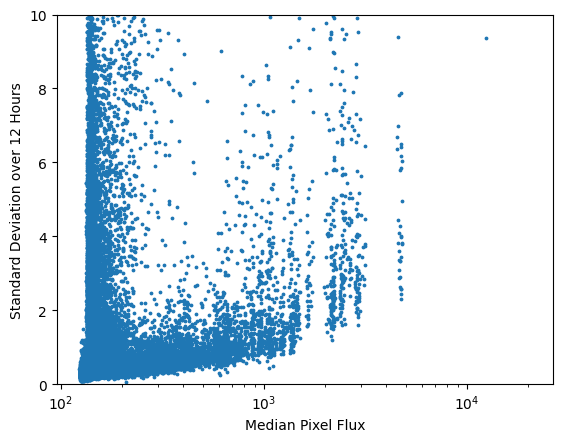

In [429]:
files =  os.listdir(data_path)
file = files[3]
tpf = lk.read(data_path + file)
med1, std1 = measure_noise(tpf, medfil_kernel=25, window=25)
        
plt.scatter(med1.flatten(), std1.flatten(), s=3)
plt.ylim([0,10])
plt.xlabel('Median Pixel Flux')
plt.ylabel('Standard Deviation over 12 Hours')
plt.xscale('log')
plt.show()


In [416]:
# loop through and build up the noise model
data_path = '../local_data/noise_model_tpfs/tesscut/'

files =  os.listdir(data_path)
file = files[0]
with fits.open(data_path + file) as hdulist:
    tpf = hdulist[1].data
    # print(tpf.data)

    med1, std1 = measure_noise(tpf1, medfil_kernel=25, window=25)
        
    plt.scatter(med1.flatten(), std1.flatten(), s=3)
    plt.ylim([0,10])
    plt.xlabel('Median Pixel Flux')
    plt.ylabel('Standard Deviation over 12 Hours')
    plt.show()


# for file in os.listdir(data_path):
    # with fits.open(data_path + file) as tpf1:
    #     med1, std1 = measure_noise(tpf1, medfil_kernel=25, window=25)
        
    #     plt.scatter(med1.flatten(), std1.flatten(), s=3)
    #     plt.ylim([0,10])
    #     plt.xlabel('Median Pixel Flux')
    #     plt.ylabel('Standard Deviation over 12 Hours')
    #     plt.show()


ValueError: Input a TESS Target Pixel File

In [426]:
tpf_big.shape

(1077, 50, 50)

In [427]:
# develop noise model based on TPF
from scipy import ndimage

def measure_noise(tpf, medfil_kernel=25, window=25):
    """Measure the characteristic noise of a pixel as a function of mean flux. medfil_kernel is the kernel size used when calculating the mediant filter. Window is in units of data points and will be affected by what the cadence of your data is, controls how long of a window will be used to calculate the standard deviation."""
    # pseudo code
    # # get median filter of raw data
    # mf_raw = ndimage.median_filter(tpf.flux.value, size=[medfil_kernel,1,1])


    # subtract background, median filter that, subtract that
    bkg = trc.fit_bkg(tpf, polyorder=3)
    mf1 = ndimage.median_filter(tpf.flux.value - bkg, size=[medfil_kernel,1,1])
    cleaned = tpf.flux.value - bkg - mf1

    # calculate running median and std 
    time = tpf.time.value
    time_bin = np.arange(time[0], time[-1], .5)
    std_bin = stats.binned_statistic(time, cleaned.reshape([tpf.shape[0],tpf.shape[1]*tpf.shape[2]]).T, bins=time_bin, statistic='std')[0]
    med_bin = stats.binned_statistic(time, tpf.flux.value.reshape([tpf.shape[0],tpf.shape[1]*tpf.shape[2]]).T, bins=time_bin, statistic='median')[0]

    # save datapoint as function of [median of raw data, std]
    return med_bin.flatten(), std_bin.flatten()

# cleaned = measure_noise(tpf_big, medfil_kernel=25, window=25)
# med1, std1 = measure_noise(tpf_big, medfil_kernel=25, window=25)


# print(np.shape(std_bin))
# print(np.shape(std_bin.flatten()))

# plt.plot(time_bin[:-1], std_bin.T)
# plt.scatter(med_bin.flatten(), std_bin.flatten(), s=3)
# plt.ylim([0,10])
# plt.xlabel('Median Pixel Flux')
# plt.ylabel('Standard Deviation over 12 Hours')
# plt.show()



In [359]:
# extracts and stores the WCS and Image data and then closes the file. Note this file is quite large and may take a few moments to dowload.

with fits.open(fits_file, mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data
    header = hdulist[1].header

Set MJD-END to 58324.833877 from DATE-END'. [astropy.wcs.wcs]


(2500, 54)
(135000,)


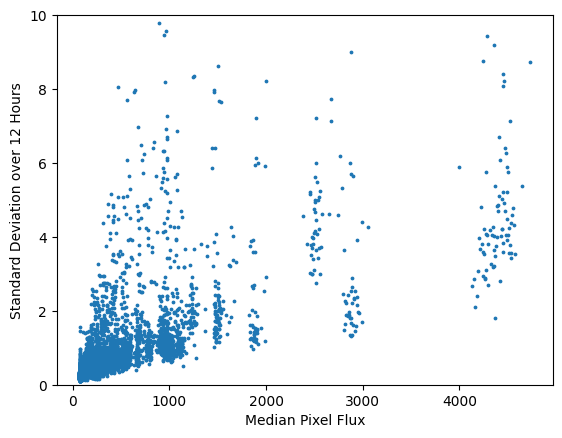

In [314]:
# develop noise model based on TPF
from scipy import ndimage

j = 0; k=0;

# print((tpf_big.time[1].value - tpf_big.time[0].value)*24)
# plt.scatter(tpf_big.time.value, tpf_big.flux[:,j,k].value, s=3)
# plt.show()

def measure_noise(tpf, medfil_kernel=25, window=25):
    """Measure the characteristic noise of a pixel as a function of mean flux. medfil_kernel is the kernel size used when calculating the mediant filter. Window is in units of data points and will be affected by what the cadence of your data is, controls how long of a window will be used to calculate the standard deviation."""
    # pseudo code
    # # get median filter of raw data
    # mf_raw = ndimage.median_filter(tpf.flux.value, size=[medfil_kernel,1,1])


    # subtract background, median filter that, subtract that
    bkg = trc.fit_bkg(tpf, polyorder=3)
    mf1 = ndimage.median_filter(tpf.flux.value - bkg, size=[medfil_kernel,1,1])
    cleaned = tpf.flux.value - bkg - mf1

    # calculate running median and std 

    # save datapoint as function of [median of raw data, std]
    return cleaned

cleaned = measure_noise(tpf_big, medfil_kernel=25, window=25)

time = tpf_big.time.value
time_bin = np.arange(time[0], time[-1], .5)
std_bin = stats.binned_statistic(time, cleaned.reshape([1077,tpf_big.shape[1]*tpf_big.shape[2]]).T, bins=time_bin, statistic='std')[0]
med_bin = stats.binned_statistic(time, tpf_big.flux.value.reshape([1077,tpf_big.shape[1]*tpf_big.shape[2]]).T, bins=time_bin, statistic='median')[0]

print(np.shape(std_bin))
print(np.shape(std_bin.flatten()))

# plt.plot(time_bin[:-1], std_bin.T)
plt.scatter(med_bin.flatten(), std_bin.flatten(), s=3)
plt.ylim([0,10])
plt.xlabel('Median Pixel Flux')
plt.ylabel('Standard Deviation over 12 Hours')
plt.show()



(1077, 20, 20)
(1077, 400)
1077


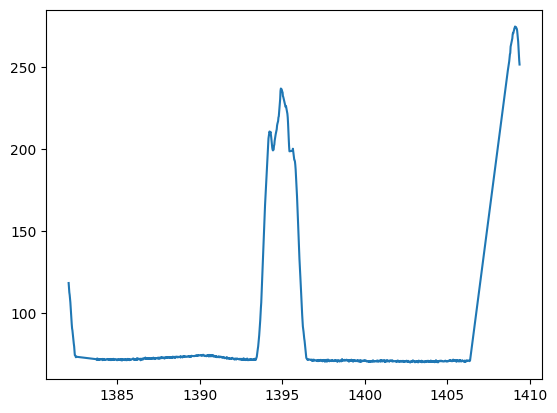

In [290]:
print(np.shape(tpf_cutout.flux.value))

test = tpf_cutout.flux.value.reshape([1077,400]).T
# test = tpf_cutout.flux.value.ravel()
print(np.shape(test))
print(len(test[0]))

# plt.plot(tpf_cutout.time.value, test[:,0])
plt.plot(tpf_cutout.time.value, test[0])
plt.show()

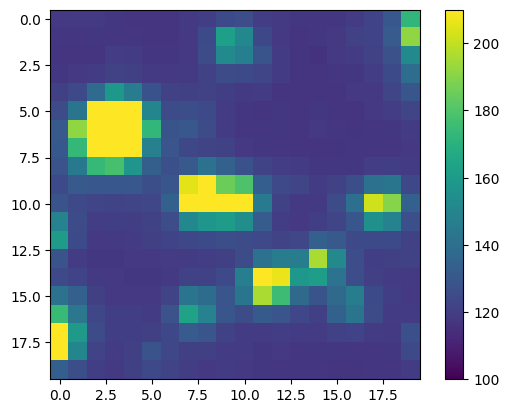

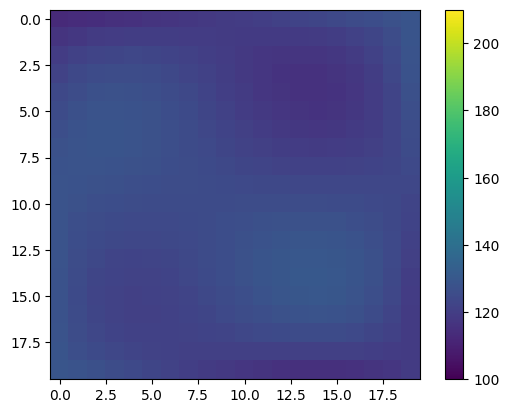

In [225]:
# debugging the fit_bkg method
imp.reload(trc)
field1 = Field(tpf_cutout, source_cat , bkg_polyorder=3)

plt.imshow(field1.orig_tpf.flux[0,:,:].value)
plt.colorbar()
plt.clim([100,210])
plt.show()

plt.imshow(field1.bkg[0,:,:])
plt.colorbar()
plt.clim([100,210])
plt.show()



# plt.imshow(trc.fit_bkg(field1.orig_tpf, polyorder=9)[0,:,:])
# plt.colorbar()
# plt.clim([100,210])
# plt.show()


0.4982059082367087
0.2506751798942799
0.2917361733266371


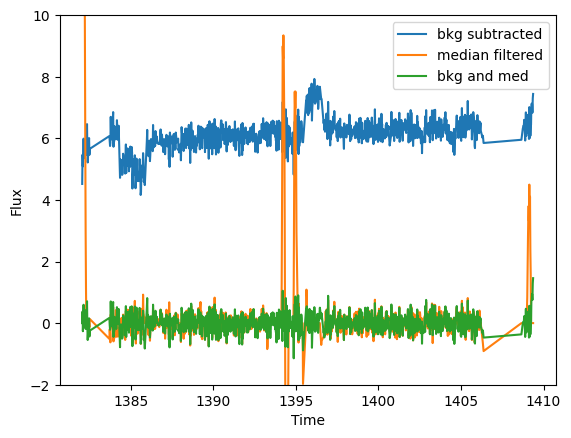

In [245]:
# try a median filter
from scipy.signal import medfilt
from astropy.stats import sigma_clip

j=6; k=0;

bkg_subbed = tpf_cutout.flux[:,j,k].value - field1.bkg[:,j,k]


# filtered = 

# # look at raw data and baground
# plt.plot(tpf_cutout.time.value, tpf_cutout.flux[:,j,k].value, label='raw')
# plt.plot(tpf_cutout.time.value, field1.bkg[:,j,k], label='bkg')
# plt.legend()
# # plt.xlim([1400,1402])
# # plt.ylim([150,205])
# plt.xlabel('Time')
# plt.ylabel('Flux')
# plt.show()



# print(len(tpf_cutout), len(filtered))
# plt.plot(tpf_cutout.time.value, tpf_cutout.flux[:,j,k].value-np.median(tpf_cutout.flux[:,j,k].value), label='raw')
# plt.plot(tpf_cutout.time.value, field1.bkg[:,j,k]-np.median(field1.bkg[:,j,k]), label='bkg')

# kernel size
ks = 25

# bkg subtracted
plt.plot(tpf_cutout.time.value, bkg_subbed, label='bkg subtracted')
print(np.std(bkg_subbed))


# median filter subtracted
median_filter = medfilt(tpf_cutout.flux[:,j,k].value, kernel_size=ks)

plt.plot(tpf_cutout.time.value, tpf_cutout.flux[:,j,k].value - median_filter, label='median filtered')
print(np.std(sigma_clip(tpf_cutout.flux[:,j,k].value - median_filter)))


# bkg and then median filtered
medbkg_filter = medfilt(bkg_subbed, kernel_size=ks)
plt.plot(tpf_cutout.time.value, bkg_subbed - medbkg_filter, label='bkg and med')
print(np.std(bkg_subbed - medbkg_filter))



# plt.plot(tpf_cutout.time.value, (tpf_cutout.flux[:,j,k].value - filtered), label='median filter')
# plt.plot(tpf_cutout.time.value, sigma_clip(tpf_cutout.flux[:,j,k].value - filtered), label='sigma_clip')
plt.ylim([-2,10])
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

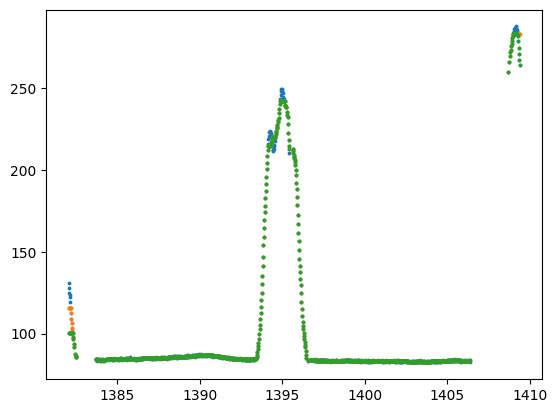

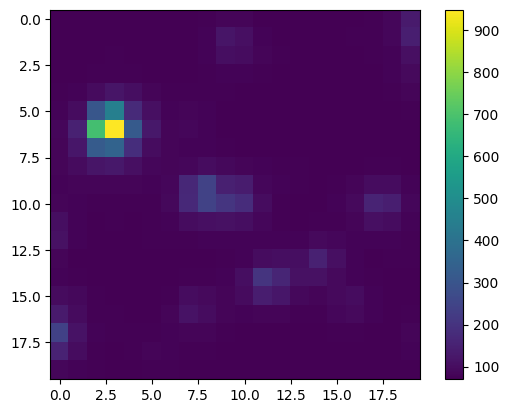

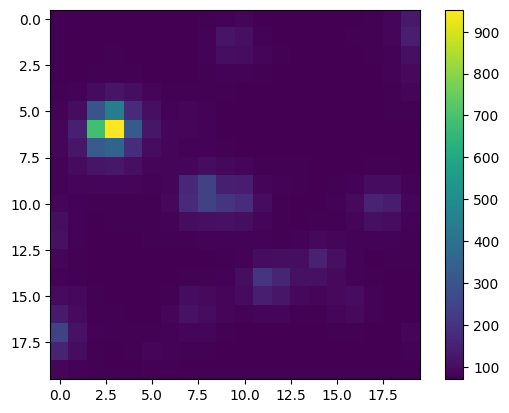

In [262]:
# try other median filter function
from scipy import ndimage
mf1 = ndimage.median_filter(tpf_cutout.flux[:,:,:].value, size=[25,1,1])

j=6; k=0;

plt.scatter(tpf_cutout.time.value, tpf_cutout.flux[:,j,k].value, s=3)
plt.scatter(tpf_cutout.time.value, mf1[:,j,k], s=3)
plt.scatter(tpf_cutout.time.value, median_filter, s=3)



plt.show()

plt.imshow(tpf_cutout.flux[100,:,:].value)
plt.colorbar()
plt.show()

plt.imshow(mf1[100,:,:])
plt.colorbar()
plt.show()

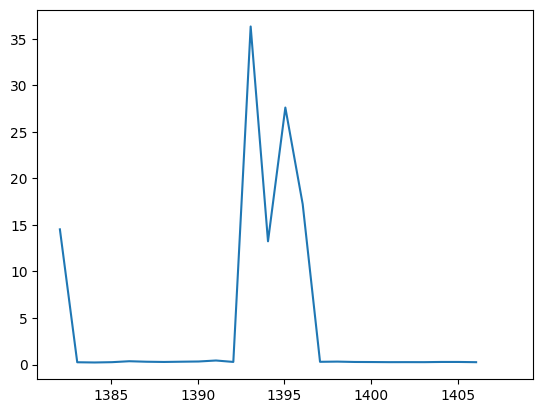

In [139]:
from scipy import stats

time = tpf_cutout.time.value

time_bin = np.arange(time[0], time[-1], 1)
std_bin = stats.binned_statistic(time, tpf_cutout.flux[:,j,k].value, bins=time_bin, statistic='std')[0]

# print(len(std_bin))

# # If flux_err is populated, assume the errors combine as the root-mean-square
# if flux_err is not None:
#     # define a function to calculate the root mean square error of each bin
#     rmse_func = (lambda x: np.sqrt(np.nansum(np.square(x))) / len(np.atleast_1d(x))
#                 if np.any(np.isfinite(x))
#                 else np.nan)
#     flux_err_bin = stats.binned_statistic(time, flux_err, statistic=rmse_func, bins=time_bin)[0]
#     return time_bin[:-1], flux_bin, flux_err_bin

plt.plot(time_bin[:-1], std_bin)
plt.show()

In [ ]:
imp.reload(trc)
def generate_kepler_prf_field(tpf_cutout, source_cat, plot=False, buffer=3):
    """Given a source catalog and tpf_cutout, generates a field with gaussian sources. Currently is very jank and just proof of concept. The list of sources in read in and then the single pixel nearest their location is given a value weighed by 16-Tmag. The plot keyword will plot the tpf_cutout and the basic field, rotated so that they hopefully line up. 

    Inputs (incomplete):
        buffer - the code will ignore any targets provided that fall more than this number of pixels outside of the tpf

    Known issues: 
    - Values are not real fluxes 
    - the pixel numbers on the axes don't line up with the real tpf pixel numbers 
    - jank rounding for ra/dec --> pixel conversion
    """
    # set up field
    field = np.ones(tpf_cutout.shape[1:])

    # convert source coords to integer pixel numbers and mags to flux
    pix1, pix2 = np.rint(tpf_cutout.wcs.all_world2pix(source_cat['ra'], source_cat['dec'], 0)).astype(int)
    flux_arr = mag_to_flux_fake(mag)

    # cut out indices where the target falls significantly outside the cutout
    shape = tpf_cutout.shape[1:]
    cut = (pix1 < shape[1]+buffer) & (pix1 >= 0-buffer) & (pix2 < shape[2]+buffer) & (pix2 >= 0-buffer)
    source_cut = source_cat[cut]

    # add sources to the field, weighted by Tmag
    for source_ind in range(len(source_cut)):
        # add the signal to the source
        signal = flux_arr[source_ind] + 10*np.sin(tpf_cutout.time.value)

        
        # make the prf for the source
        simpleprf = lk.prf.SimpleKeplerPRF(channel=44, shape=(10, 10), column=5, row=5) # doctest: +SKIP
        # Downloading http://archive.stsci.edu/missions/kepler/fpc/prf/kplr13.4_2011265_prf.fits [Done]

        prf = kepprf(flux=2000, center_col=10, center_row=10, scale_row=0.7, scale_col=0.7, rotation_angle=math.pi/2) # doctest: +SKIP

        sprf = simpleprf(flux=2000, center_col=10, center_row=10, ) # doctest: +SKIP




        # make the gaussian
        gauss = trc.makeGaussian(shape[1], shape[2], fwhm=fwhm_arr[source_ind], center=[pix1[source_ind],pix2[source_ind]]) * fwhm_arr[source_ind]

        # add in a signal
        signal = np.sin(tpf_cutout.time.value)
        gauss_blink = np.multiply(signal[:, np.newaxis, np.newaxis], gauss[np.newaxis, :, :])

        # add to the field
        field = np.add(field, gauss_blink)
        # field = np.add(field, gauss[np.newaxis, :, :])
        # field[:,pix1[cut],pix2[cut]] = 16 - source_cat['Tmag'][cut]

    # plot if requested
    if plot:
        plt.imshow(np.rot90(field[0].T))
        plt.colorbar()
        plt.show()
        tpf_cutout.plot();
    
    return field

gauss_field = generate_gaussian_field(tpf_cutout, source_cat, plot=True, buffer=3)

### TESS and Kepler PRF scratch

In [ ]:
# Figure out the kepler PRF
# __init__() missing 4 required positional arguments: 'channel', 'shape', 'column', and 'row'

# issues: As far as I can tell, TESS doesn't separate out channels the way Kepler does
# "Unlike the Kepler CBV files, we generate one per CCD rather than a single file that contains all the CCD channels." Not totally sure how to handle this, so I'm just picking an arbitrary channel until the TESS prfs get implemented.
out = lk.prf.SimpleKeplerPRF(channel=1, shape=(5,5), column=tpf_cutout.column, row=tpf_cutout.row)   #tpf_cutout.shape[1:]

print(out(tpf_cutout.column, tpf_cutout.row))


[[ 2.20590456e-01  5.27744420e-03  1.58727570e-04  4.60579854e-05
  -6.08302197e-06]
 [ 1.84833061e-02  7.48281404e-04  1.17885737e-04 -8.40902267e-06
  -1.66863589e-11]
 [ 2.37513440e-03  1.65545574e-04  3.87796920e-05 -1.47104128e-05
   8.63081265e-21]
 [ 4.50140034e-04  3.80719527e-05 -4.31103717e-06  4.18279407e-16
   7.47840615e-45]
 [ 2.09805796e-05 -1.01671539e-11 -4.20132062e-22  6.71819091e-45
   9.16393180e-74]]


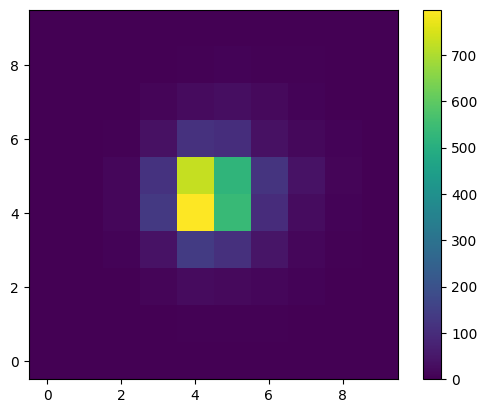

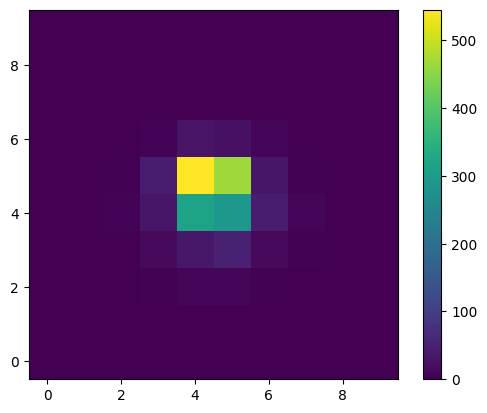

In [ ]:
import math
kepprf = lk.prf.KeplerPRF(channel=44, shape=(10, 10), column=5, row=5) # doctest: +SKIP
simpleprf = lk.prf.SimpleKeplerPRF(channel=44, shape=(10, 10), column=5, row=5) # doctest: +SKIP
# Downloading http://archive.stsci.edu/missions/kepler/fpc/prf/kplr13.4_2011265_prf.fits [Done]

prf = kepprf(flux=2000, center_col=10, center_row=10, scale_row=0.7, scale_col=0.7, rotation_angle=math.pi/2) # doctest: +SKIP

sprf = simpleprf(flux=2000, center_col=10, center_row=10, ) # doctest: +SKIP

plt.imshow(prf, origin='lower') # doctest: +SKIP
plt.colorbar()
plt.show()

plt.imshow(sprf, origin='lower') # doctest: +SKIP
plt.colorbar()
plt.show()

0.9999999999999997


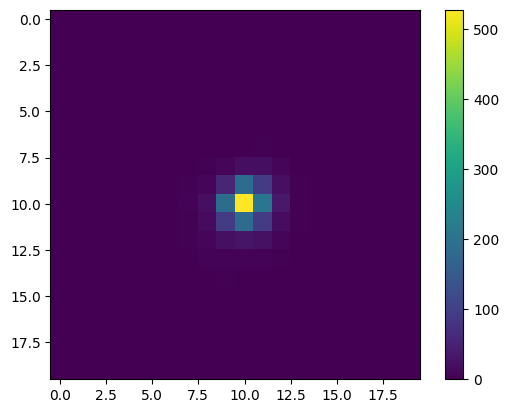

In [45]:
# Figure out the TESS PRF
import PRF
# import matplotlib.pyplot as plt

# # tpf_cutout.meta
# # ('CAMERA', 3), ('CCD', 4), ('SECTOR', 3)
# print(tpf_cutout.row, tpf_cutout.column)

# pix1, pix2 = np.rint(
#         tpf_cutout.wcs.all_world2pix(source_cat["ra"], source_cat["dec"], 0)
#     ).astype(int)
# # pix1, pix2

# Suppose the following for a TPF of interest
cam = tpf_cutout.meta['CAMERA']
ccd = tpf_cutout.meta['CCD']
sector = tpf_cutout.meta['SECTOR']
colnum = tpf_cutout.column #middle of TPF
rownum = tpf_cutout.row #middle of TPF

prf = PRF.TESS_PRF(cam,ccd,sector,colnum,rownum)

# See what this looks like in the center of an 11x11 TPF
resampled = prf.locate(10.0, 10.0, (20,20))

print(np.sum(resampled))

plt.imshow(resampled*2000)
plt.colorbar()
plt.show()

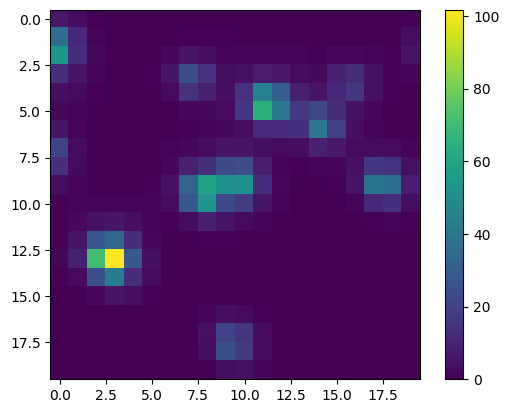

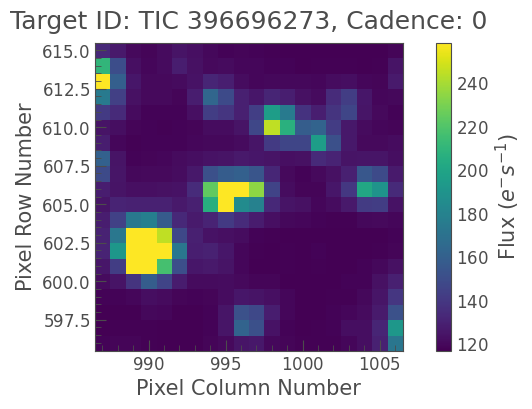

In [69]:
imp.reload(trc)
def generate_prf_field(tpf_cutout, source_cat, plot=False, buffer=3):
    """Given a source catalog and tpf_cutout, generates a field with gaussian sources. Currently is very jank and just proof of concept. The list of sources in read in and then the single pixel nearest their location is given a value weighed by 16-Tmag. The plot keyword will plot the tpf_cutout and the basic field, rotated so that they hopefully line up. 

    This version uses the TESS_PRF package.

    Inputs (incomplete):
        buffer - the code will ignore any targets provided that fall more than this number of pixels outside of the tpf

    Known issues: 
    - Values are not real fluxes 
    - the pixel numbers on the axes don't line up with the real tpf pixel numbers 
    - jank rounding for ra/dec --> pixel conversion
    """
    # set up field
    shape = tpf_cutout.shape[1:]
    field = np.zeros(shape)

    # convert source coords to pixel numbers and int pixel numbers
    pix1, pix2 = tpf_cutout.wcs.all_world2pix(source_cat['ra'], source_cat['dec'], 0)
    pix1int = np.rint(pix1).astype(int)
    pix2int = np.rint(pix2).astype(int)

    # convert flux to mag (FIX LATER)
    flux_arr = trc.mag_to_flux_fake(source_cat['Tmag'])

    # cut out indices where the target falls significantly outside the cutout
    
    cut = (pix1int < shape[0]+buffer) & (pix1int >= 0-buffer) & (pix2int < shape[1]+buffer) & (pix2int >= 0-buffer)
    source_cut = source_cat[cut]

    # retrieve the prf for this tpf
    # Suppose the following for a TPF of interest
    cam = tpf_cutout.meta['CAMERA']
    ccd = tpf_cutout.meta['CCD']
    sector = tpf_cutout.meta['SECTOR']
    colnum = tpf_cutout.column #middle of TPF?
    rownum = tpf_cutout.row #middle of TPF?

    prf = PRF.TESS_PRF(cam,ccd,sector,colnum,rownum)

    # add sources to the field, weighted by Tmag
    for source_ind in range(len(source_cut)):
        # add the signal to the source
        signal = flux_arr[source_ind] + 10*np.sin(tpf_cutout.time.value)

        # resample to make the prf for the source
        source_prf = prf.locate(pix1[source_ind],pix2[source_ind], shape)

        # apply the prf to the signl and add to image
        gauss_blink = np.multiply(signal[:, np.newaxis, np.newaxis], source_prf[np.newaxis, :, :])

        # add to the field
        field = np.add(field, gauss_blink)
        # field = np.add(field, gauss[np.newaxis, :, :])
        # field[:,pix1[cut],pix2[cut]] = 16 - source_cat['Tmag'][cut]

    # plot if requested
    if plot:
        plt.imshow(np.rot90(field[0].T))
        plt.colorbar()
        plt.show()
        tpf_cutout.plot();
    
    return field

gauss_field = generate_prf_field(tpf_cutout, source_cat, plot=True, buffer=3)

### Point field and wcs

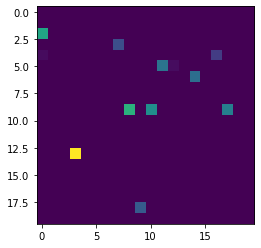

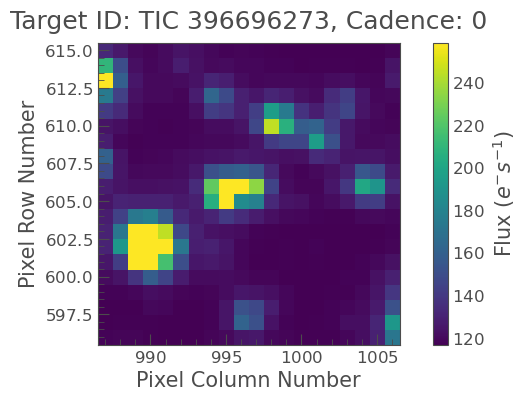

In [326]:
imp.reload(trc)
field = trc.generate_basic_field(tpf_cutout, source_cat, plot=True)


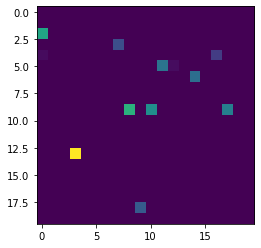

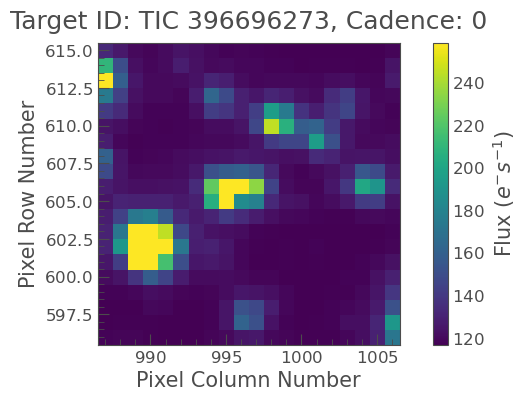

In [320]:
# set up the fake star field
# imp.reload(trc)
field = np.zeros_like(tpf_cutout.flux.value)
# print(np.shape(tpf_cutout))
# print(np.shape(field))

# ra1, dec1 = source_cat[0]['ra'], source_cat[0]['dec']
pix1, pix2 = np.rint(tpf_cutout.wcs.all_world2pix(source_cat['ra'], source_cat['dec'], 0)).astype(int)

# cut out indices where the target falls outside the cutout
shape = np.shape(field)
cut = (pix1 < shape[1]) & (pix1 >= 0) & (pix2 < shape[2]) & (pix2 >= 0)

# change the pixels where the sources fall to 1
# np.shape(field)
# print(pix1)
# print(pix2)
# print(len(pix1, len(pix2)))
field[:,pix1[cut],pix2[cut]] = 16 - source_cat['Tmag'][cut]

plt.imshow(np.rot90(field[0]))
plt.show()
tpf_cutout.plot();


In [327]:
tpf_cutout.wcs.all_world2pix(source_cat['ra'], source_cat['dec'], 0)


[array([ 9.70511727,  7.7981655 , 11.03109983, 11.35948497, 12.3170203 ,
        14.13558002,  7.21036813, 17.48693711, 15.76887041,  2.69348503,
         9.34087545,  0.3642109 , -0.96172894, -0.32423597, 20.17730921,
        11.42148789, -3.92073258, 23.4416721 , 20.77676878, 12.01715741]),
 array([10.13428224,  9.54006985, 14.34524306, 14.32941418, 14.09736932,
        13.19673262, 15.75029646, 10.04488305, 15.43915221,  5.95346347,
         1.41768788, 15.17050864, 11.67830826, 17.31719713, 17.16910284,
        -3.15026896,  7.54283231,  6.86975334,  0.40723979, -4.4445014 ])]

In [194]:
# grab the positional catalog
from astroquery.mast import Catalogs
import astropy.units as u
import astropy.wcs as wcs


catalog_data = Catalogs.query_object(name, catalog="TIC", radius=trc.pixels_to_radius(cutout_size))

# catalog_data = Catalogs.query_object(name, catalog="TIC", width=trc.pix_to_arcsec(cutout_size)*u.arcsecond)

print(len(catalog_data))
print(len(catalog_data[catalog_data['Tmag'] < 16]))

# print(catalog_data[:10])


129
20


In [143]:
imp.reload(trc)
# px = 20
# # trc.roundup(px / np.sqrt(2) * 21 / 3600, pow=-2)
# trc.pixels_to_radius(20)

<module 'trc_funcs' from '/Users/raeholcomb/Library/CloudStorage/GoogleDrive-rjholcom@uci.edu/My Drive/Research/rotation_collab/trc/trc_funcs.py'>

In [202]:
import astropy.io.fits as fits
import os
filename = os.path.join(wcs.__path__[0], 'tests/data/j94f05bgq_flt.fits')
hdulist = fits.open(filename)
# hdulist[('sci',1)].header
# w = wcs.WCS(hdulist[('sci',1)].header, hdulist)
# hdulist.close()



WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 5.63056810618  -72.05457184278998  
CRPIX : 2048.0  1024.0  
CD1_1 CD1_2  : 1.29056256197165e-05  5.95309123310338e-06  
CD2_1 CD2_2  : 5.0220581265601e-06  -1.2644774105568e-05  
NAXIS : 1  1

In [218]:
w = tpf_cutout.wcs
radec = w.all_pix2world([1,2,3], [1,1,1], 1)
ra1, dec1 = w.all_pix2world([1,2,3], [1,1,1], 1)
print(radec)
print(ra1, dec1)

recover_pix = w.all_world2pix(radec[0], radec[1], 1)
recover_pix1 = w.all_world2pix(ra1, dec1, 1)
print(recover_pix)
print(recover_pix1)


[array([65.33176083, 65.33716003, 65.34255794]), array([-55.22266473, -55.2178913 , -55.21311764])]
[65.33176083 65.33716003 65.34255794] [-55.22266473 -55.2178913  -55.21311764]
[array([1., 2., 3.]), array([1., 1., 1.])]
[array([1., 2., 3.]), array([1., 1., 1.])]


In [ ]:
# start making fake starfield


# Developing Signal Injection

## Making my own Model class

In [457]:
import typing

In [166]:
funcs = {'sin':(np.sin, 10), 'cos':(np.cos, 20)}

print(list(zip(*funcs.values()))[1])

(10, 20)


In [385]:
class MixtureModel(stats.rv_continuous):
    def __init__(self, submodels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.submodels = submodels
        # self.dist = 'MixtureModel'
        # self.kwds = ''

    def _pdf(self, x):
        pdf = self.submodels[0].pdf(x)
        for submodel in self.submodels[1:]:
            pdf += submodel.pdf(x)
        pdf /= len(self.submodels)
        return pdf

    def rvs(self, size):
        submodel_choices = np.random.randint(len(self.submodels), size=size)
        submodel_samples = [submodel.rvs(size=size) for submodel in self.submodels]
        rvs = np.choose(submodel_choices, submodel_samples)
        return rvs

mixture_gaussian_model = MixtureModel([stats.norm(-3, 1), stats.norm(3, 1)])
x_axis = np.arange(-6, 6, 0.001)
mixture_pdf = mixture_gaussian_model.pdf(x_axis)
mixture_rvs = mixture_gaussian_model.rvs(10)

typing.List[typing.Tuple[str, float]]

Sine Function
	B: 2
	D: 3
	A: <scipy.stats._continuous_distns.norm_gen>, {'loc': 10, 'scale': 3}
	D: MixtureModel
		['<scipy.stats._continuous_distns.norm_gen>', '<scipy.stats._continuous_distns.norm_gen>']
		[{'loc': -3, 'scale': 2}, {'loc': 3, 'scale': 1}]

{'B': 2, 'D': 3.564479632566832, 'A': 12.971814354416477}
200


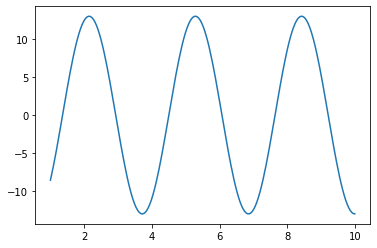

In [442]:

class FunctionSelector:
    """Used to select what functions get inputed.
    TO DO: restrict function input types."""
    def __init__(self, generators: typing.List[typing.Tuple[TSGenerator, float]] = None):
        self.generators = {}
        self.weights = {}
        
        if generators is not None:
            for item in generators:
                self.generators[item[0].name] = item[0]
                self.weights[item[0].name] = item[1]
        # self.weights = {}

    def __str__(self) -> str:
        output = ''
        for key, value in self.generators.items():
            output += 'Name: ' + key + ', Weight: ' + str(value[1]) + '\n'
        return output
    
    def print_verbose() -> str:
        """Prints out a long version, with all the functions and their kwargs listed."""
        pass

    def add_generator(self, name, generator, weight):
        """Adds a function to the options which can be selected.
        TO DO: restrict function input types."""
        self.generators[name] = (generator, weight)
        # self.weights[name] = weight

    def delete_function(self, name):
        """Deletes a function from the selection options."""
        del self.generators[name]
        # del self.weights[name]

    def select_function(self):
        selected_key = random.choices(list(zip(*self.funcs.values()))[0], weights=list(zip(*self.funcs.values()))[1])
        return selected_key
    
    def instantiate_function(self, time):
        # pick what type of function
        func = self.select_function()[0]
        print(func)

        # apply the function to the time array and return the flux and the selected args
        # print(type(selected_key))
        # func = self.funcs[selected_key][0]
        flux, params = func.generate_signal(time)
        return flux, params

del fs
fs = FunctionSelector()
# fs.add_function('sin', SignalFunction('sin', np.sin), 10)
# fs.add_function('cos', SignalFunction('cos', np.cos), 20)
fs.add_function('sine1', sine1, 10)

# print(fs)
fs.select_function()

time = np.linspace(1,10,200)
flux, params = fs.instantiate_function(time)
plt.plot(time,flux)
plt.show()


In [446]:
stats.uniform(loc=1,scale=0).rvs(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [490]:
isinstance(stats.norm(loc=1,scale=1).dist, stats.rv_continuous)
type(stats.norm(loc=1,scale=1).dist)


scipy.stats._continuous_distns.norm_gen

In [491]:
typing.Dict[str,stats.rv_continuous]

TypeError: 'type' object is not subscriptable

In [525]:
class MockUp:
    def __init__(self, name, params:typing.Dict[str,float]) -> None:
        # define each arg distribution in the definition
        # func needs to be in the format func(time, **kwargs)
        # name must be a string
        self.name = name

        # loop through and assign the parameters to class variables
        for key, value in params.items():
            setattr(self, key, value)

        # print(type(self.__dict__))

        for attr, value in self.__dict__.items():
            print( attr, value)
        pass

    def __str__(self) -> str:
        
        return getattr
    
    def __iter__(self):
        for attr, value in self.__dict__.items():
            yield attr, value

test = MockUp('test', {'a':1, 'b':2})
# for item in test:
#     print(item)
t1 = test.__dict__.copy()
del t1['name']
t1['a'] = 3

print(test.__dict__, t1)

name test
a 1
b 2
{'name': 'test', 'a': 1, 'b': 2} {'a': 3, 'b': 2}


In [554]:
class TSGenerator:
    """A generic class that generates a signal in a light curve."""
    def __init__(self, name, params:typing.Dict[str,stats.rv_continuous]) -> None:
        # define each arg distribution in the definition
        # func needs to be in the format func(time, **kwargs)
        # name must be a string
        self.name = name

        # loop through and assign the parameters to class variables
        for key, value in params.items():
            setattr(self, key, value)
        pass

    def __str__(self) -> str:
        # print out a summary of the args and their distributions
        output = str(self.name) + '\n'
        # loop through and add distribution parameters
        for key, value in self.__dict__.items():
            if key == 'name':
                continue
            elif isinstance(value, MixtureModel):
                output += '\t' + key + ': ' + 'MixtureModel' + '\n'
                output += '\t\t' + str([str(model.dist).split(" ")[0] + '>' for model in value.submodels]) + '\n'
                output += '\t\t' + str([model.kwds for model in value.submodels])  + '\n'
            elif isinstance(value.dist, stats.rv_continuous):
                output += '\t' + key + ': ' + str(value.dist).split(" ")[0] + '>, ' + str(value.kwds) + '\n'
            else: 
                output += '\t' + key + ': ' + 'Unrecognized distribution type' + '\n'
        
        return output
        
    def change_param_distribution(self, name:str, distr) -> None:
        """Provide a distribution for a particular parameter. Must be a [input format here]."""
        setattr(self, name, distr)
        pass

    def delete_param_distribution(self, name:str) -> None:
        """add"""
        delattr(self, name)
        pass

    def draw_parameter_values(self) -> typing.Dict:
        """Pulls a value from each parameter distribution."""
        # iterate over the parameters and pull one value from each distribution
        param_values = self.__dict__.copy()
        del param_values['name']
        for key, distr in param_values.items():
            param_values[key] = distr.rvs(1)[0]
        return param_values

    def generate_signal(self, time, **kwargs) -> typing.Tuple[np.ndarray, typing.Dict] :
        """To be supplied by the user. Must take time as a positional argument, and return a tuple containing the flux array as the first argument and a dictionary with the selected parameter values as the second."""
        raise NotImplementedError

        # make copy of the kwargs for this specific instantiation
        params = self.kwargs.copy()

        # draw parameter values from the distributions
        for key, value in self.distributions.items():
            params[key] = value.rvs(1)[0]
        
        print(params)
        print(len(time))

        # calculate the flux
        flux = self.func(time, **params)
        return flux, params

sine2 = TSGenerator("Sine Function", 
                       {'A':stats.norm(loc=10, scale=3),
                                      'D': test_dist})
print(sine2.draw_parameter_values())
# sine2.generate_signal([1,2,3])
print(sine2)


{'A': 10.732720175595986, 'D': 1.6817479925751408}
Sine Function
	A: <scipy.stats._continuous_distns.norm_gen>, {'loc': 10, 'scale': 3}
	D: MixtureModel
		['<scipy.stats._continuous_distns.norm_gen>', '<scipy.stats._continuous_distns.norm_gen>']
		[{'loc': -3, 'scale': 2}, {'loc': 3, 'scale': 1}]



In [425]:
# OLD Signal Function class
class SignalFunction:
    """A generic class that generates a signal in a light curve."""
    def __init__(self, name, func, distributions={}, args=[], kwargs={}) -> None:
        # define each arg distribution in the definition
        # func needs to be in the format func(time, **kwargs)
        # name must be a string

        for key, value in self.kwargs.items():
            setattr(self, key, value)
    
        self.name = name
        self.func = func
        self.args = args
        self.distributions = distributions
        self.kwargs = kwargs
        pass

    def __str__(self) -> str:
        # print out a summary of the args and their distributions
        output = str(self.name) + '\n'
        # loop through and add kwargs
        for key, value in self.kwargs.items():
            output += '\t' + key + ': ' + str(value) + '\n'
        # loop through and add distribution parameters
        for key, value in self.distributions.items():
            if isinstance(value, MixtureModel):
                output += '\t' + key + ': ' + 'MixtureModel' + '\n'
                output += '\t\t' + str([str(model.dist).split(" ")[0] + '>' for model in value.submodels]) + '\n'
                output += '\t\t' + str([model.kwds for model in value.submodels])  + '\n'
            elif isinstance(value.dist, stats.rv_continuous):
                output += '\t' + key + ': ' + str(value.dist).split(" ")[0] + '>, ' + str(value.kwds) + '\n'
            else: 
                output += '\t' + key + ': ' + 'Unrecognized distribution type' + '\n'
        
        return output
        
    def change_param_distribution(self, name, distr):
        """Provide a distribution for a particular parameter. Must be a [input format here]."""
        self.distributions[name] = distr
        pass

    def select_parameter_values(self):
        raise NotImplementedError

    def generate_signal(self, time):
        # make copy of the kwargs for this specific instantiation
        params = self.kwargs.copy()

        # draw parameter values from the distributions
        for key, value in self.distributions.items():
            params[key] = value.rvs(1)[0]
        
        print(params)
        print(len(time))

        # calculate the flux
        flux = self.func(time, **params)
        return flux, params


In [ ]:
# Inherited TSGenerator to make a sine function
class SineTSGenerator(TSGenerator):

    def __init__(self, A:float|stats.distribution=1, offset:float|stats.distribution=0):
    """
    Sine?

    Parameters
    ----------

    A: stats.Normal
        
    """
        self.A = convert_to_distribution(A)
        self.offset = convert_to_distribution(offset)

    def sample(self, time)->np.ndarray:
        """....size time"""
        return np.sin(self.A.sample() * time) + self.offset.sample()

    def __repr__(self):
        return "SineTSGenerator"


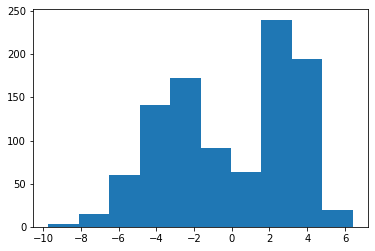

Sine Function
	B: 2
	D: 3
	A: <scipy.stats._continuous_distns.norm_gen>, {'loc': 10, 'scale': 3}
	D: MixtureModel
		['<scipy.stats._continuous_distns.norm_gen>', '<scipy.stats._continuous_distns.norm_gen>']
		[{'loc': -3, 'scale': 2}, {'loc': 3, 'scale': 1}]

{'B': 2, 'D': -5.530187197174397, 'A': 9.71684493941537}
50


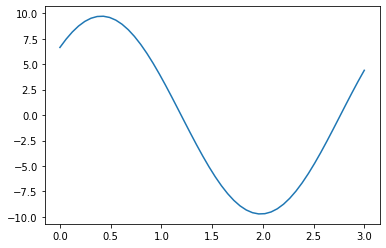

In [438]:
def test_sin(time, A=1, B=1, C=0, D=0):
    """ y = A * sin(B(x+C) + D)"""
    return A * np.sin(B*(time+C) + D)
    
test_dist = MixtureModel([stats.norm(loc=-3, scale=2), stats.norm(loc=3, scale=1)])

plt.hist(test_dist.rvs(1000))
plt.show()

sine1 = SignalFunction("Sine Function", test_sin, 
                       kwargs={'B':2, 'D':3},
                       distributions={'A':stats.norm(loc=10, scale=3),
                                      'D': test_dist})

print((sine1))

x = np.linspace(0,3,50)
y, params = sine1.generate_signal(x)

plt.plot(x,y)
plt.show()


In [ ]:
__post_init__()
setattr, getattr, hasattr,

In [384]:
print(isinstance(test_dist, MixtureModel))
print(isinstance(stats.norm(loc=-3, scale=2).dist, stats.rv_continuous))
print(type(stats.norm(loc=-3, scale=2)))

True
True
<class 'scipy.stats._distn_infrastructure.rv_continuous_frozen'>


In [366]:
print([str(model.dist).split(" ")[0] + '>' for model in test_dist.submodels])
print([model.kwds for model in test_dist.submodels])

['<scipy.stats._continuous_distns.norm_gen>', '<scipy.stats._continuous_distns.norm_gen>']
[{'loc': -3, 'scale': 1}, {'loc': 3, 'scale': 1}]


In [319]:
# dist = stats.norm(loc=0.0,scale=1.0)
dist = stats.uniform(loc=0.0,scale=1.0)
dist.rvs(10)

print(type(dist))
print(dist.kwds)
print(dist.dist)
print(str(dist.dist).split(" ")[0] + '>')
# print(dist.__dict__['kwds'])


<class 'scipy.stats._distn_infrastructure.rv_continuous_frozen'>
{'loc': 0.0, 'scale': 1.0}
<scipy.stats._continuous_distns.uniform_gen>


[]

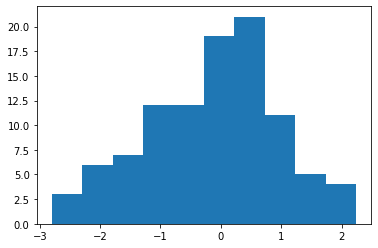

In [331]:
points = stats.cosine().rvs(100)
plt.hist(points)
plt.plot()

In [237]:
# # with statements and context managers
# https://realpython.com/python-with-statement/
# https://github.com/pymc-devs/pymc/blob/main/pymc/model.py
# https://docs.python.org/3/reference/compound_stmts.html#with
# https://docs.python.org/3/library/stdtypes.html#contextmanager.__exit__

# with sine1 as model:
#     var1 = 12

#     def __enter__(self):
#         return self

#     def __exit__(self, type, value, tb):
#         pass

# sine1.var1

AttributeError: 'SignalFunction' object has no attribute 'var1'

## Pymc3 distribution function

In [23]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

In [115]:
import numpy as np
import scipy.stats as ss


with pm.Model():
    mu = pm.Normal('mu', 0 , 1)
    normal_dist = pm.Normal.dist(mu, 1)
    dens = pm.DensityDist(
        'density_dist',
        normal_dist.logp,
        observed=np.random.randn(100),
        random=ss.norm.rvs,
    )
    prior = pm.sample_prior_predictive(10)['density_dist']

TypeError: The DensityDist API has changed, you are using the old API where logp was the first positional argument. In the current API, the logp is a keyword argument, amongst other changes. Please refer to the API documentation for more information on how to use the new DensityDist API.

In [114]:
import pytensor.tensor as at

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = pm.DensityDist('beta', logp=lambda value: -1.5 * at.log(1 + value**2))
    eps = pm.DensityDist('eps', logp=lambda value: -at.log(at.abs_(value)))
    
    # Create likelihood
    # like = pm.Normal('y_est', mu=alpha + beta * X, sigma=eps, observed=Y)

pm.draw(beta, draws=1000)


NotImplementedError: Attempted to run random on the CustomDist 'CustomDist_beta', but this method had not been provided when the distribution was constructed. Please re-build your model and provide a callable to 'CustomDist_beta's random keyword argument.

Apply node that caused the error: CustomDist_beta_rv{0, (), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FB93D9349E0>), TensorConstant{[]}, TensorConstant{11})
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, (0,)), TensorType(int64, ())]
Inputs shapes: ['No shapes', (0,), ()]
Inputs strides: ['No strides', (8,), ()]
Inputs values: [Generator(PCG64) at 0x7FB93D9349E0, array([], dtype=int64), array(11)]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [143]:
eb_model = pm.Model()
model2 = pm.Model()

mu = 1
sigma = 1

# Define the uniform distribution parameters
a = 0
b = 2

with eb_model:
    # period = Gaussian in log space, mu=10^.5, sigma = 10^.5. Note conversion from base 10 to base e.
    period = pm.LogNormal('period', mu=np.log(10**.5), sigma=np.log(10**.4))

    # sbratio -
    # var = pm.Normal('var', mu=mu, tau=1/sigma**2) + pm.Uniform('var_uniform', lower=a, upper=b)
    # sbratio = pm.DensityDist('sbratio', logp=lambda value: -1.5 * (1 + value**2))
    x1 = pm.Normal('x1', mu=1, sigma=1) 
    mu = x + x1

    # Define a new variable with hard limits at 0 and 3
    # BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    # var = BoundedNormal('var', mu=1.0, sigma=3.0)
    # var_bounded = pm.Bound(pm.Normal, lower=0, upper=3)('var_bounded', mu=var, tau=1/sigma**2)
    # var = pm.Bound(pm.Normal, lower=0.0)('var', mu=1.0, sigma=3.0)

    # normal_dist = pm.Normal.dist(mu=0.0, sigma=1.0)
    # truncated_normal = pm.Truncated("truncated_normal", normal_dist, lower=-1, upper=1)

    # temp = pm.Normal.dist(mu=1, sigma=.2) + pm.Uniform.dist(lower=0.1, upper=1)
    sbratio = pm.Truncated("sbratio", pm.Normal.dist(mu=1, sigma=.2), lower=0, upper=1) + pm.Uniform("temp1", lower=0.1, upper=1)



    

# with model2:
#     # period = pm.LogNormal('period', mu=0.5, sigma=0.5)
#     x1 = pm.Normal('x1', mu=100, sigma=1)
#     mu = x + x1

# y = pm.Binomial.dist(n=10, p=0.5)

TypeError: __new__() got multiple values for argument 'name'

In [146]:
# Define the normal distribution parameters
mu = 1
sigma = 1

# Define the uniform distribution parameters
a = 0
b = 2

with pm.Model() as model:
    # Define the variable with the combined distribution
    var = pm.Normal('var', mu=mu, tau=1/sigma**2) + pm.Uniform('var_uniform', lower=a, upper=b)

    pm.Deterministic('new', var)

# Print the 10 random draws
# print(draws)


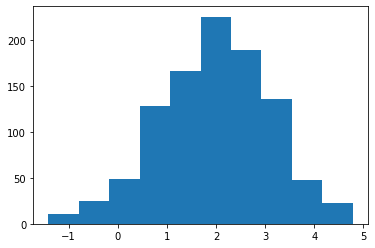

In [149]:
# x_draws = pm.draw(eb_model.temp1, draws=1000)
x_draws = pm.draw(model.new, draws=1000)
plt.hist(x_draws)
# plt.hist(x_draws,bins=np.logspace(np.log10(0.1),np.log10(100.0), 30))
# plt.xscale('log')
plt.show()


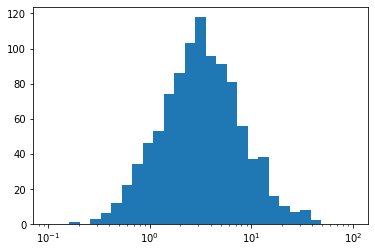

In [92]:
x_draws = pm.draw(period, draws=1000)
plt.hist(x_draws,bins=np.logspace(np.log10(0.1),np.log10(100.0), 30))
plt.xscale('log')
plt.show()


In [87]:
np.log(10**.5)

1.151292546497023

In [18]:
# x_draws = pm.draw(mu, draws=10)
x_draws = pm.draw(eb_model.basic_RVs)
x_draws

[array(0.29419921), array(10.1681101)]

In [26]:
x = pm.Normal.dist(mu=0, sigma=1)
x.random(size=3)


In [10]:
fmodel = pm.Model()



NameError: name 'time' is not defined

In [ ]:
flux = ellc.lc(time, radius_1=r_1, radius_2=r_2,
        incl=incl,sbratio=sbratio,period=period, t_zero=t_zero,
        f_c=f_c, f_s=f_s)

## Eclipsing Binaries

In [226]:
import ellc

Make a "generate normalized light curve" class
- Start with a generic class
- then subclass it to make specific instances for EB, rotators, etc.
- Ideally generator classes will take in the same arguments every time

Look into pmcy3 to better handle distributions

In [ ]:
# set up generic LC generator class
class LCGenerator:
    """Docstring"""
    def __init__(self) -> None:
        ()

    def  


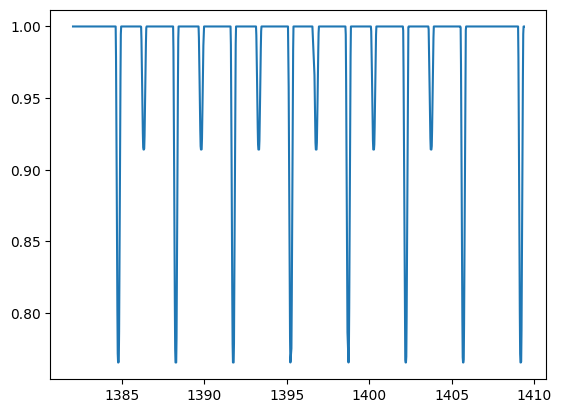

In [352]:
def sample_eb_sbratio():
    """Some kind of kluge that is somewhat similar to an inverse gaussian? Extremely jank, only use with caution and testing."""
    mu = 1
    sigma = 2
    x1 = np.random.rand()*.7 + .2
    y = np.exp(-sigma * ((x1-mu)**2)/(2*x1*(mu**2))) * .8 + 2 #/ np.sqrt(2 * np.pi * (x**3))    
    return y

def sample_eb_period():
    """Gaussian in log space, mu=10^.5, sigma = 10^.5
    Currently ignoring the bump from contact binaries (until I figure out how to simulate those better)
    """
    return 10**(np.random.normal(.5, .4))

def sample_eb_eccentricity():
    """Use y = .5 * x^2 to transform the window [0,1) for eccentricity. Setting omega to 0 or pi controls the positive/negative phase."""
    return np.random.rand()**2 * .5

def generate_eb(time, *args):
    """
    Generate a random eclipsing binary system given a set of timestamps. Returned lightcurve will be normalized to 1.
    """
    # sbratio = 2
    r_1 = 0.09992 
    r_2 = 0.19726
    incl = 85

    ecc = sample_eb_eccentricity()
    om  = np.random.choice([0,np.pi]) # positive or negative phase
    f_c = np.sqrt(ecc)*np.cos(om)
    f_s = np.sqrt(np.abs(ecc - f_c**2))  # f_s = np.sqrt(ecc)*np.sin(om)

    # period distribution, gaussian in log space with mu=10^.5, sigma = 10^.4
    # Currently ignoring the bump from contact binaries 
    period = sample_eb_period()
    sbratio = sample_eb_sbratio()
    t_zero = period * np.random.rand() # total system phase

    # generate the flux
    flux = ellc.lc(time, radius_1=r_1, radius_2=r_2,
        incl=incl,sbratio=sbratio,period=period, t_zero=t_zero,
        f_c=f_c, f_s=f_s)
    return flux

# orbital period distribution: gaussian in log space peaked at 3 days
eb_time = tpf_cutout.time.value
eb_flux = generate_eb(eb_time)

plt.plot(eb_time, eb_flux)
plt.show()


In [224]:
np.random.rand()

0.3025478044893748

In [220]:
sample_eb_period()

array([1.43592775])

In [95]:
10**(np.random.normal(.5, .5))

3.993372004108833

2.032739297284382


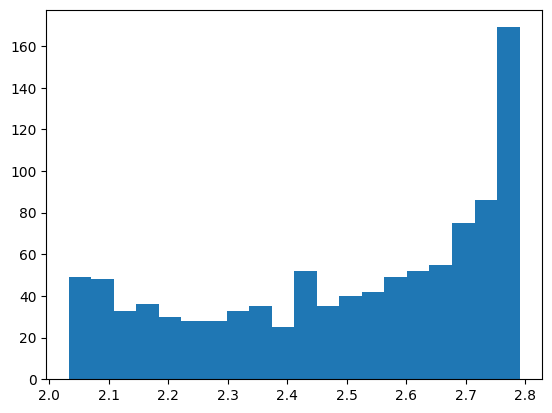

In [340]:
# developing sbratio distribution
# def gaus(X,C,X_mean,sigma):
#     # C = 1.0 / (np.sqrt(2.0 * np.pi) * sigma)
#     y = 200*np.exp(-(X-X_mean)**2/(2*sigma**2)) + 50
#     return y #/ sum(y)

mu = 1
sigma = 2
x1 = np.random.rand(1000)*.7 + .2
y1 = np.exp(-sigma * ((x1-mu)**2)/(2*x1*(mu**2))) * .8 + 2 #/ np.sqrt(2 * np.pi * (x**3))


# x = np.linspace(.01,1,100)
# y = invgaus(x,1,.1)
# # # print(sum(y))
# plt.plot(x,y)
# # # plt.ylim(0,250)
# plt.show()

# y = sbratio(np.random.rand(1000))
print(min(y1))
# y = 1 - np.abs(np.random.normal(0,.1,1000))
# y = 10**(np.random.normal(.5, .4, 1000))
plt.hist(y1,bins= 20)
plt.show()


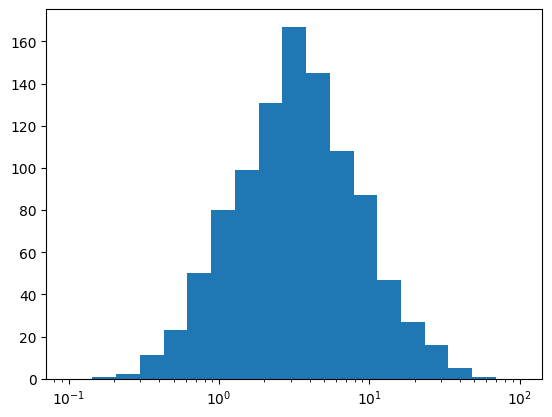

In [98]:
# make period distribution
# y = np.random.randn(1000)
y = 10**(np.random.normal(.5, .4, 1000))
plt.hist(y,bins=np.logspace(np.log10(0.1),np.log10(100.0), 20))
plt.xscale('log')
plt.show()

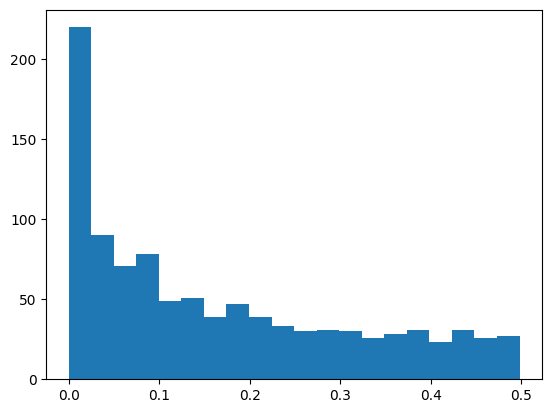

In [275]:
# make eccentricity distribution
# strongly peaked at zero, max out at .5
# y = np.random.randn(1000)
# y = np.random.normal(.0, .25, 1000)**2
y = np.random.rand(1000)**2 * .5
plt.hist(y,bins=20)
# plt.xscale('log')
plt.show()

In [ ]:
# <!-- <function ellc.lc.lc(t_obs, 
# radius_1, radius_2, 
# sbratio, incl, light_3=0, 
# t_zero=0, period=1, a=None, q=1, 
# f_c=None, f_s=None, 
# ldc_1=None, ldc_2=None, 
# gdc_1=None, gdc_2=None, 
# didt=None, domdt=None, 
# rotfac_1=1, rotfac_2=1, 
# hf_1=1.5, hf_2=1.5, bfac_1=None, bfac_2=None, 
# heat_1=None, heat_2=None, lambda_1=None, lambda_2=None, 
# vsini_1=None, vsini_2=None, t_exp=None, 
# n_int=None, grid_1='default', grid_2='default', 
# ld_1=None, ld_2=None, shape_1='sphere', 
# shape_2='sphere', 
# spots_1=None, spots_2=None, exact_grav=False, verbose=1)> -->

For now (until I figure out custom distributions):
- period: continuous from .3 to 50 days
- inclination: Always 90, control the eclipse depths by the sbratio instead
- sbratio: uniform from .2 to 1

- t_zero: uniform from 0 to period
- ecc and omega:
    - ecc will be strongly peaked at 0 with a tail going down and maxing at .5
    - omega will be either 0 or 180


Planned distributions:
 - Period: normal distr (in log space) w/ peak at 10^.5 days and that goes from ~.1-.3 to ~10^1.5 days

 - inclination: Always 90, control the eclipse depths by the sbratio instead

 - sbratio: uniform from .2 to 1, then add a half gaussian peak at 1

 Reference: https://iopscience.iop.org/article/10.3847/1538-4365/ac324a#apjsac324as5


In [134]:
ecc = 0.15
# om  = (180+120) * np.pi/180.
om  = 0
f_c = np.sqrt(ecc)*np.cos(om)
# f_s = np.sqrt(ecc)*np.sin(om)
f_s = np.sqrt(np.abs(ecc - f_c**2))

print(ecc, om)
print(f_c, f_s)
# print((f_c**2 + f_s**2)/ecc)

0.15 0
0.3872983346207417 5.268356063861754e-09


In [100]:
10**1.5

31.622776601683793

In [149]:
(180+120) * np.pi/180.

5.235987755982989

In [257]:
# 180 * float(True)


180

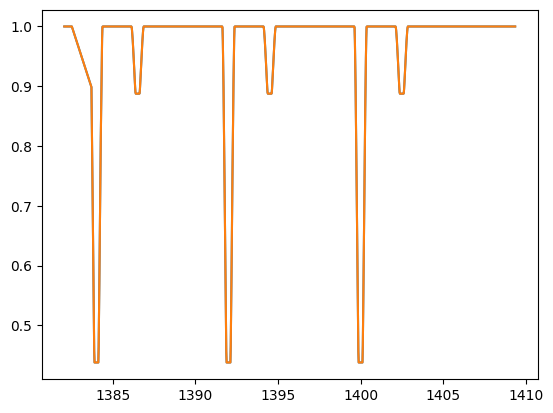

In [334]:
sbratio = .2
r_1 = 0.09992 
r_2 = 0.19726
incl = 90
period = 8

ecc = 0.3
om  = (180) * np.pi/180.
f_c = np.sqrt(ecc)*np.cos(om)
f_s = np.sqrt(np.abs(ecc - f_c**2))  # f_s = np.sqrt(ecc)*np.sin(om)

test1 = ellc.lc(tpf_cutout.time.value, radius_1=r_1, radius_2=r_2,
        incl=incl,sbratio=sbratio,period=period, t_zero=0, rotfac_1=1,
         f_c=f_c, f_s=f_s)
test2 = ellc.lc(tpf_cutout.time.value, radius_1=r_1, radius_2=r_2,
        incl=incl,sbratio=sbratio,period=period, t_zero=0, rotfac_1=10,
         f_c=f_c, f_s=f_s)
# test3 = ellc.lc(tpf_cutout.time.value, radius_1=r_1, radius_2=r_2,
#         incl=incl,sbratio=sbratio,period=8, t_zero=0)
plt.plot(tpf_cutout.time.value, test1)
plt.plot(tpf_cutout.time.value, test2)
# plt.plot(tpf_cutout.time.value, test3)
# plt.xlim([1390,1395])
plt.show()


In [34]:
print(ellc.lc.__doc__)


  Calculate the light curve of a binary star

  This function calculates the light curve of a binary star using the ellc
  binary star model [1].

  Parameters
  ----------
  t_obs : array_like
      Times or phases of observation. The units and time system used must be
      consistent with t_zero and period.

  radius_1 : float
      Radius of star 1 in units of the semi-major axis of the binary.
      The radius is defined to be the same as a sphere with the same volume as
      the ellipsoid used to approximate the shape of the star.
      Set radius_1=1 to fix radius at limiting radius in the Roche potential.

  radius_2 : float
      Radius of star 2 in units of the semi-major axis of the binary.
      The radius is defined to be the same as a sphere with the same volume as
      the ellipsoid used to approximate the shape of the star.
      Set radius_2=1 to fix radius at limiting radius in the Roche potential.

  sbratio : float
      Surface brightness ratio, S_2/S_1 

  incl

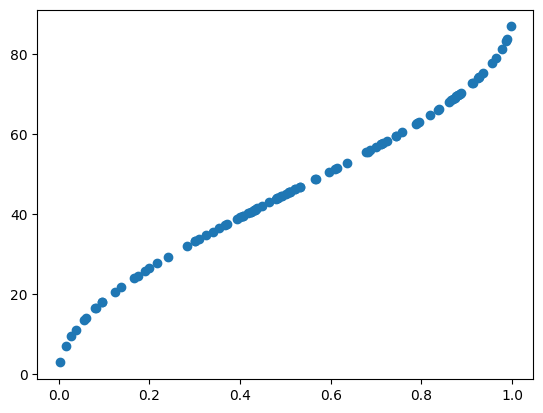

1.5707963267948966


In [68]:
# uniform distribution in sin^2 i

def inclination_distr(low=0.0, high=1.0, size=None) :
    """Generates an inclination angle from 0-90 in degrees drawn from a distritubion that is uniform in sin^2(i) space. Low and high are inputted in radians."""
    y_distr = np.random.uniform(low=low, high=high, size=size)
    i_distr = convert_to_inclination(y_distr)
    # convert radians to degrees
    return y_distr, i_distr / np.pi * 180.


def convert_to_inclination(y):
    """Given a valure, solves for the inclination in the equation y = sin^2(i)."""
    return np.arcsin(np.sqrt(y))

# incl = np.linspace(0,np.pi/2,100)
# plt.plot(incl, np.sin(incl)**2)
# plt.show()

# sin2 = np.linspace(0,1, 100)
# plt.plot(sin2, np.sqrt(sin2))
# plt.plot(sin2, convert_to_inclination(sin2))

arr1, arr2 = inclination_distr(low=0.0, high=1.0, size=100)

plt.scatter(arr1, arr2)
plt.show()
print(np.pi / 2)

In [66]:
inclination_distr(low=0.0, high=1., size=4)


(array([0.31533548, 0.76672776, 0.27091452, 0.23654662]),
 array([34.16287814, 61.11961439, 31.3654272 , 29.10165274]))

In [ ]:
# mess around with sampling
import numpy as np
import scipy.interpolate as interpolate

x = np.linspace

def inverse_transform_sampling(data, n_bins=40, n_samples=1000):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)


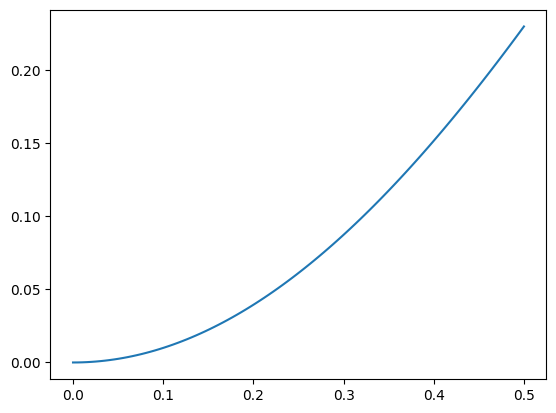

In [9]:
x = np.linspace(0,.5,100)
y = np.sin(x)**2

plt.plot(x,y)
plt.show()

In [12]:
# mess around with distributions
from scipy.stats import rv_continuous

class my_pdf(rv_continuous):
    def _pdf(self,x):
        # return 3*x**2  # Normalized over its range, in this case [0,1]
        return np.sin(x)  # Normalized over its range, in this case [0,1]

my_cv1 = my_pdf(a=0, b=1, name='my_pdf1')
my_cv2 = my_pdf(a=0, b=5, name='my_pdf2')
my_cv3 = my_pdf(a=0, b=.5, name='my_pdf3')

draws1 = my_cv1.rvs(size=1000)
draws2 = my_cv2.rvs(size=1000)
draws3 = my_cv3.rvs(size=1000)

# gaussian = my_pdf(name='gaussian')
plt.hist(draws1)
plt.show()

# plt.plot(my_cv1.pdf(np.linspace(0,2,100)))
# plt.plot(my_cv2.pdf(np.linspace(0,2,100)))

plt.hist(draws2)
plt.show()

plt.hist(draws3)
plt.show()



/Users/raeholcomb/Library/Python/3.8/lib/python/site-packages/scipy/stats/_distn_infrastructure.py:2052: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/raeholcomb/Library/Python/3.8/lib/python/site-packages/scipy/stats/_distn_infrastructure.py:2052: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/raeholcomb/Library/Python/3.8/lib/python/site-packages/scipy/stats/_distn_infrastructure.py:2052: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a

KeyboardInterrupt: 

In [5]:
import phoebe
logger = phoebe.logger()

In [18]:
# make default system
b = phoebe.default_binary()

# set parameters
b.set_value(qualifier='teff', component='primary', value=6500)

# set the dataset
b.add_dataset('lc', times=tpf_cutout.time.value)



<ParameterSet: 80 parameters | contexts: constraint, compute, dataset, figure>

In [22]:
# compute observables
b.run_compute()


100%|██████████| 1077/1077 [00:26<00:00, 39.99it/s]


<ParameterSet: 3 parameters | qualifiers: times, comments, fluxes>

In [26]:
print(b.filter(context='compute'))

ParameterSet: 19 parameters
     sample_from@phoebe01@compute: []
        comments@phoebe01@compute: 
      use_server@phoebe01@compute: none
   dynamics_method@phoebe01@co...: keplerian
            ltte@phoebe01@compute: False
    irrad_method@phoebe01@compute: horvat
   boosting_method@phoebe01@co...: none
   eclipse_method@phoebe01@com...: native
   horizon_method@phoebe01@com...: boolean
   mesh_method@primary@phoebe0...: marching
   mesh_method@secondary@phoeb...: marching
   ntriangles@primary@phoebe01...: 1500
   ntriangles@secondary@phoebe...: 1500
   distortion_method@primary@p...: roche
   distortion_method@secondary...: roche
     atm@primary@phoebe01@compute: ck2004
   atm@secondary@phoebe01@compute: ck2004
         enabled@phoebe01@compute: True
      fti_method@phoebe01@compute: none


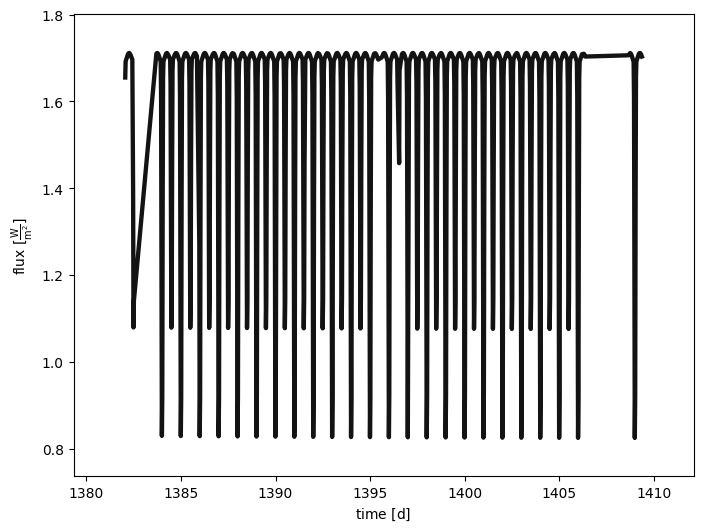

In [24]:
# print(b.get_value(qualifier='fluxes', context='model'))
afig, mplfig = b.plot(show=True)

In [ ]:
def generate_signal(time):
    """Swappable rotation/other signal-generating code. Should always return [time, flux]"""
    return np.sin(time) + 1

121.848206
(1077, 20, 20)


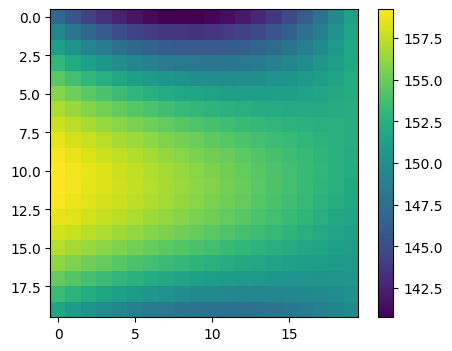

In [ ]:
# work on modeling the background
# first step is to use the source catalog to mask sources
print(np.median(tpf_cutout[0].flux.value))
np.median(tpf_cutout.flux.value, axis=[1,2])

# bkg = trc.estimate_bkg(tpf_cutout, source_cat)
# plt.close('all')
bkg = trc.fit_bkg(tpf_cutout, polyorder=2)
print(np.shape(bkg))
plt.figure(figsize=[5,4])
plt.imshow(bkg[100])
plt.colorbar()
plt.show()

